In [1]:
%matplotlib inline
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.stats import stats


from biosppy.signals import tools as st
from biosppy.signals import eda
from biosppy.signals import ecg
from biosppy.signals import emg
from biosppy.signals import resp
from biosppy.signals import tools as st
from biosppy import plotting, utils

from scipy import signal

In [2]:
def ploteventtrait(plt, eventtmp):
    for index, row in eventtmp.iterrows():
        #mywidth=np.fabs(row['arousal'])+1
        if row['arousal']>0:
            pos_down = 0.5
            pos_up= 0.5+0.15 * row['arousal']
        else:
            pos_down = 0.5 + 0.15*row['arousal']-0.02
            pos_up= 0.5
        plt.axvline(row['rela_point']-3,color='r',ymin=pos_down, ymax=pos_up,linewidth=2)
        
    for index, row in eventtmp.iterrows():
        #mywidth=np.fabs(row['valence'])+1
        if row['valence']>0:
            pos_down = 0.5
            pos_up= 0.5+0.15 * row['valence']
        else:
            pos_down = 0.5 + 0.15*row['valence']-0.02
            pos_up= 0.5
        plt.axvline(row['rela_point']+3,color='g',ymin=pos_down, ymax=pos_up,linewidth=2)   

    
def subject_level(sujet,sequence):
    mbf=pd.read_csv('./../out/matbutFeature.csv',encoding='utf-16')
    sdf=mbf.groupby(['sujet','match']).first().reset_index()
    ns=int(sdf.loc[(sdf['sujet']==sujet) & (sdf['match']==int(sequence[1])),'niveausub'])
    nm=int(sdf.loc[(sdf['sujet']==sujet) & (sdf['match']==int(sequence[1])),'niveaumat'])
    return (ns,nm)

def plotseq(chunkdf,sujet, sequence,eventtmp):
    fig = plt.figure(figsize=(30,20))
    ns,nm=subject_level(sujet,sequence)
    figurename='S'+str(sujet)+'_'+sequence
    fig.suptitle('S'+str(sujet)+'_'+sequence + ': sujetlevel '+str(ns)+'_matchlevel '+str(nm), fontsize=30)
    gs = gridspec.GridSpec(6,1)
     # raw signal
    l=len(chunkdf)
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(range(l), chunkdf['hr'], linewidth=1, label='Heart Rate')
    #ax1.legend()
    ax1.set_ylabel('HR')
    ploteventtrait(plt,eventtmp)

    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
    ax2.plot(range(l), chunkdf['rsp'], linewidth=1, label='Respiration')
    #ax2.legend()
    ax2.set_ylabel('Respiration')
    ploteventtrait(plt,eventtmp)

    ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)
    ax3.plot(range(l), chunkdf['eda'], linewidth=1, label='EDA')
    #ax3.legend()
    ax3.set_ylabel('EDA')
    ploteventtrait(plt,eventtmp)

    ax4 = fig.add_subplot(gs[3, 0], sharex=ax1)
    ax4.plot(range(l), chunkdf['acc'], linewidth=1, label='Acceleration')
    #ax4.legend()
    ax4.set_ylabel('Acceleration')
    ploteventtrait(plt,eventtmp)

    ax5 = fig.add_subplot(gs[4, 0], sharex=ax1)
    ax5.plot(range(l), chunkdf['emg_s'], linewidth=1, label='emg_s')
    #ax5.legend()
    ax5.set_ylabel('EMG_m')
    ploteventtrait(plt,eventtmp)

    ax6 = fig.add_subplot(gs[5, 0], sharex=ax1)
    ax6.plot(range(l), chunkdf['emg_f'], linewidth=1, label='emg_f')
    #ax6.legend()
    ax6.set_ylabel('EMG_f')
    ploteventtrait(plt,eventtmp)


    savename='./../plottrans/'+figurename+'.pdf'
    fig.savefig(savename,dpi=100)
    #plt.show()
    plt.close()   
    


In [4]:
def get_sec(row,col):
    s=row[col]
    l = s.split(':')
    return int(l[0]) * 3600 + int(l[1]) * 60 + int(l[2])

Mdf={}
Datapath='./../Matchjrn/'
Matchfilepath='./../biopacMatch/'
Biofilepath="./../biopac/"
biofilelist=[]
for fn in os.listdir(Biofilepath):
    biofilelist.append(fn)

num=0
for fn in os.listdir(Datapath):
    num=num+1
    sujet = re.split(r'\s*[.\-\s]\s*', fn)[1]  # M - S2.csv
    #print num, sujet
    matchfile = Datapath + fn
    #print matchfile
    Mdfname=sujet
    df=pd.read_csv(matchfile,sep=',',header=None,index_col=0)
    df[3]=df.apply (lambda row: get_sec(row,1),axis=1)
    df[4]=df.apply (lambda row: get_sec(row,2),axis=1)
    df[5]=df[4]-df[3]
    df=df.loc[['base0','en1','en2','base1','m11','m12','base2','m21','m22','base3','m31','m32'],:]
    df.loc[['base0','base1','base2','base3'],6]=df.loc[:,4]-180
    df.loc[['en1','en2','m11','m12','m21','m22','m31','m32'],6]=df.loc[:,4]-240
    df[6]=df[6].astype(int)
    #df_o=df[[6,4]]
    Mdf[Mdfname]=df

    
dfAll = pd.read_csv('./../out/Allevent.txt',encoding='utf-16',index_col=0)

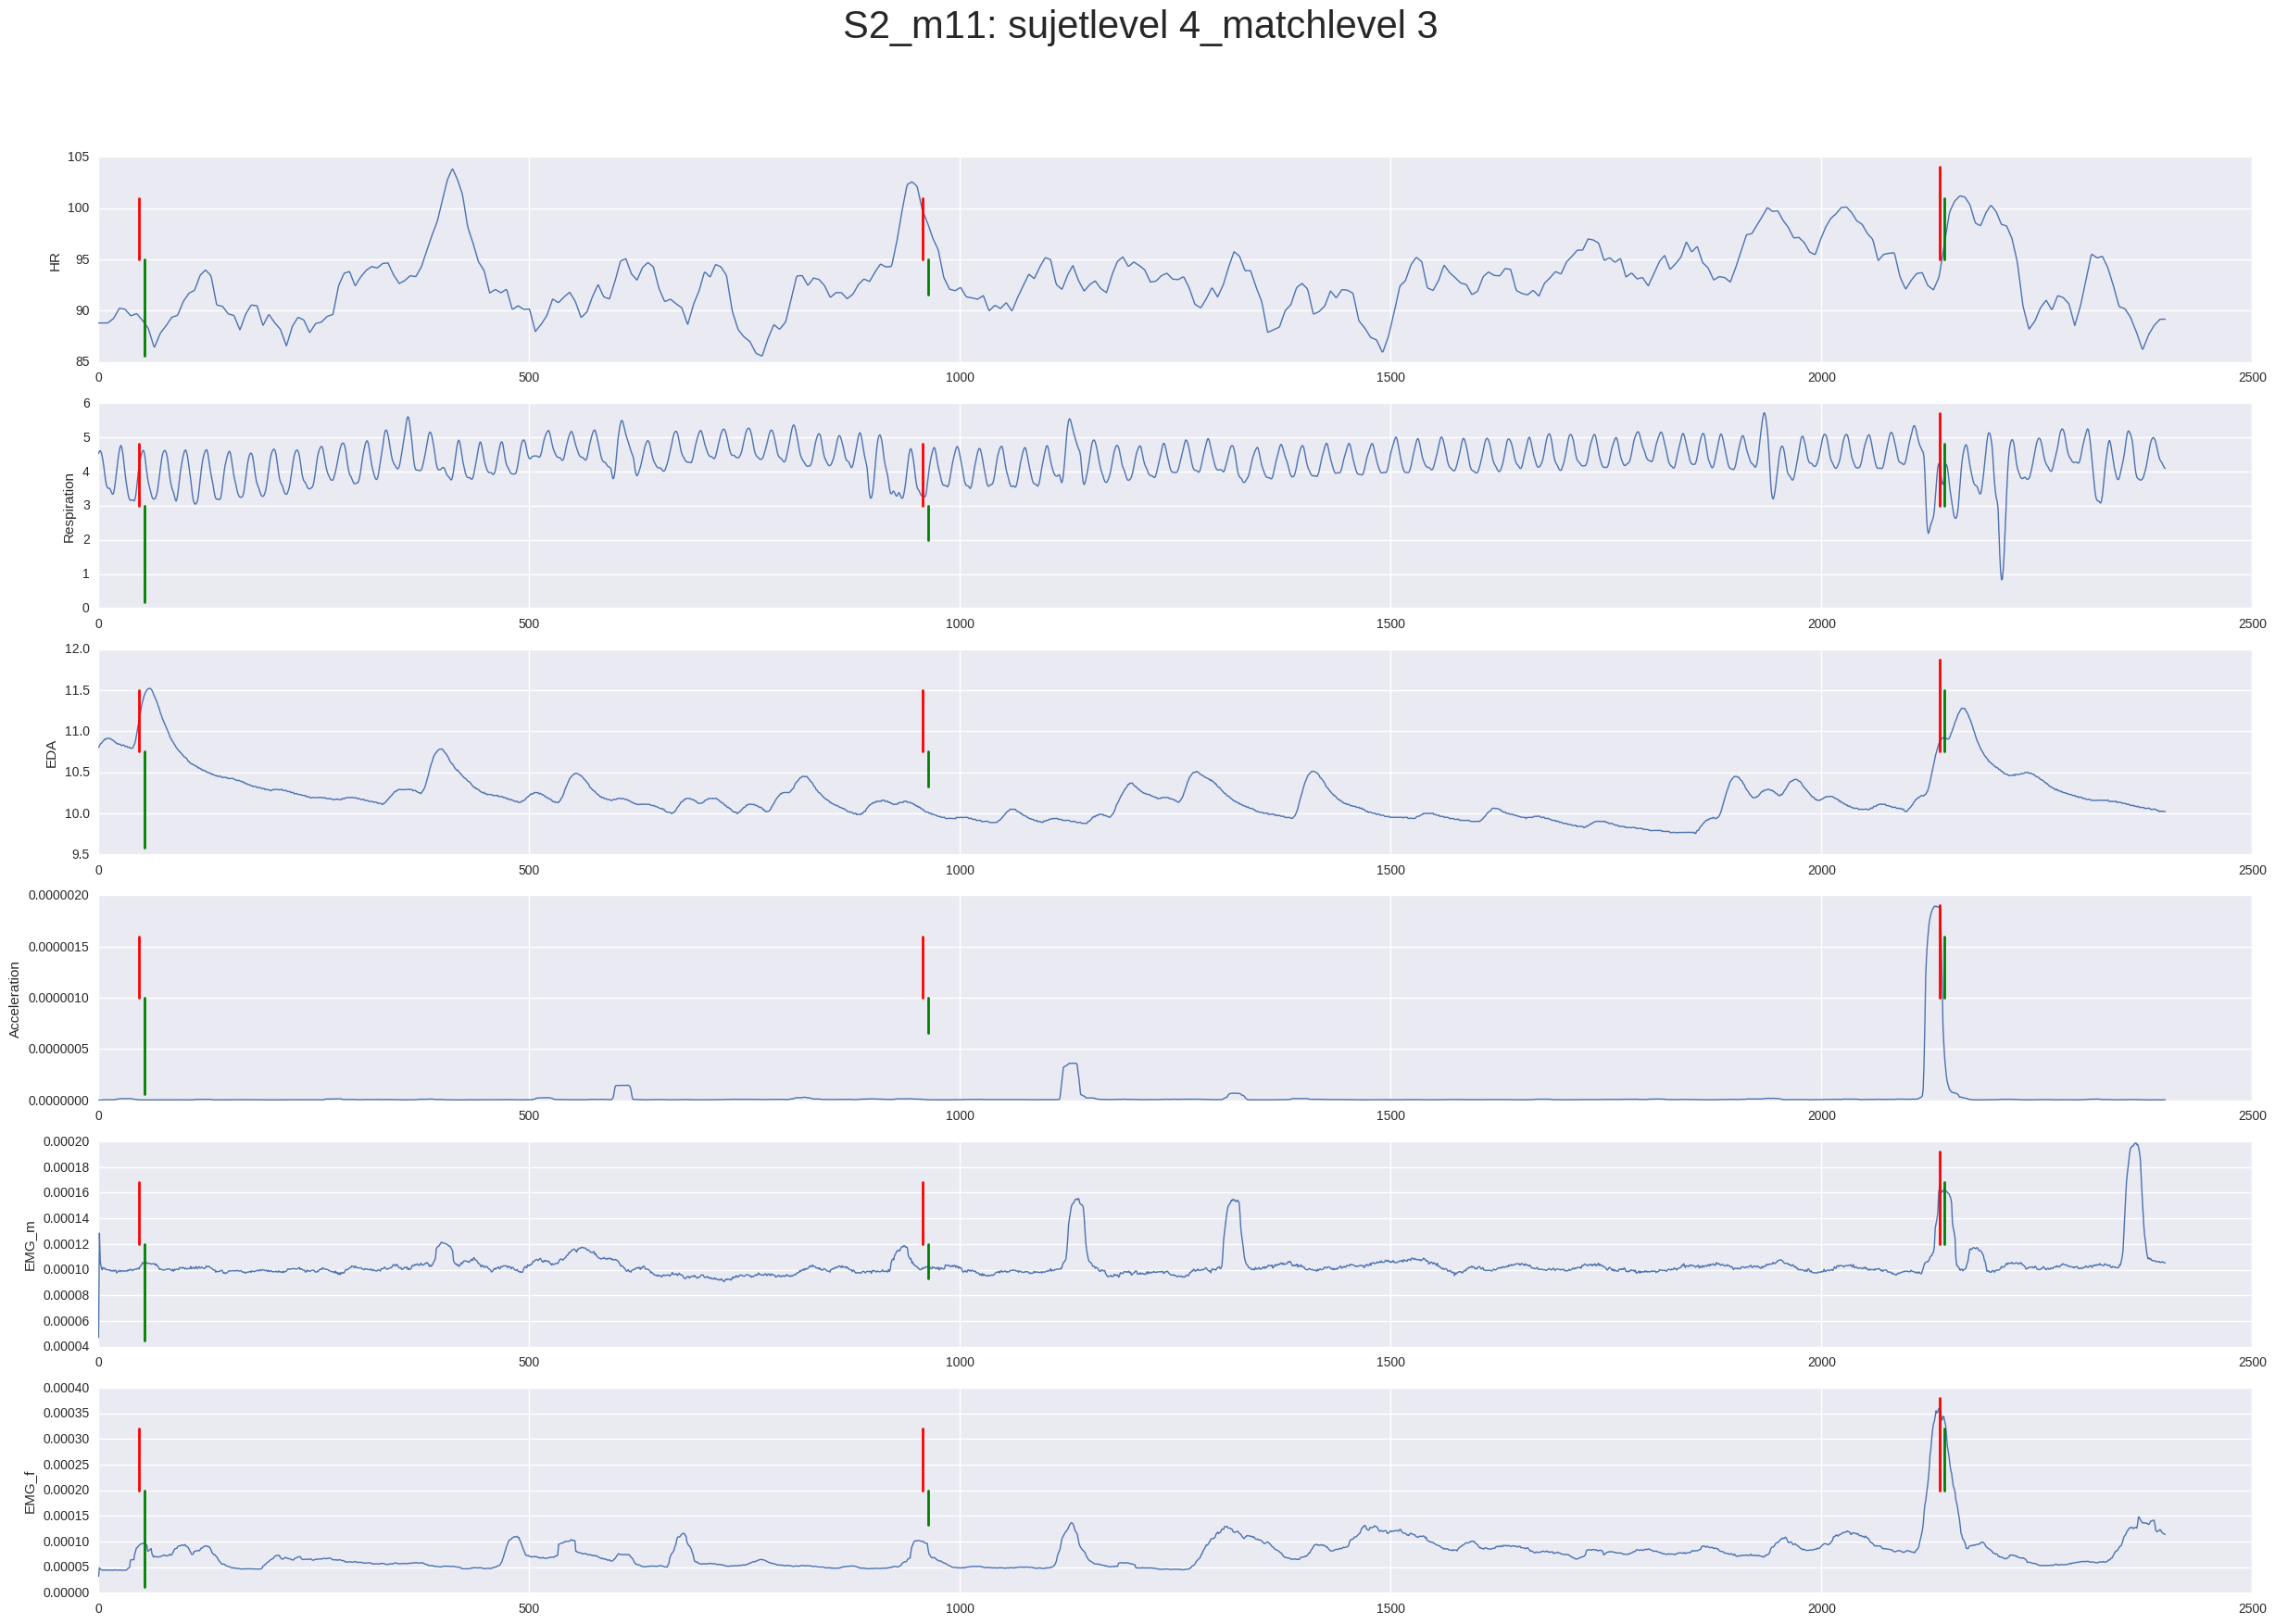

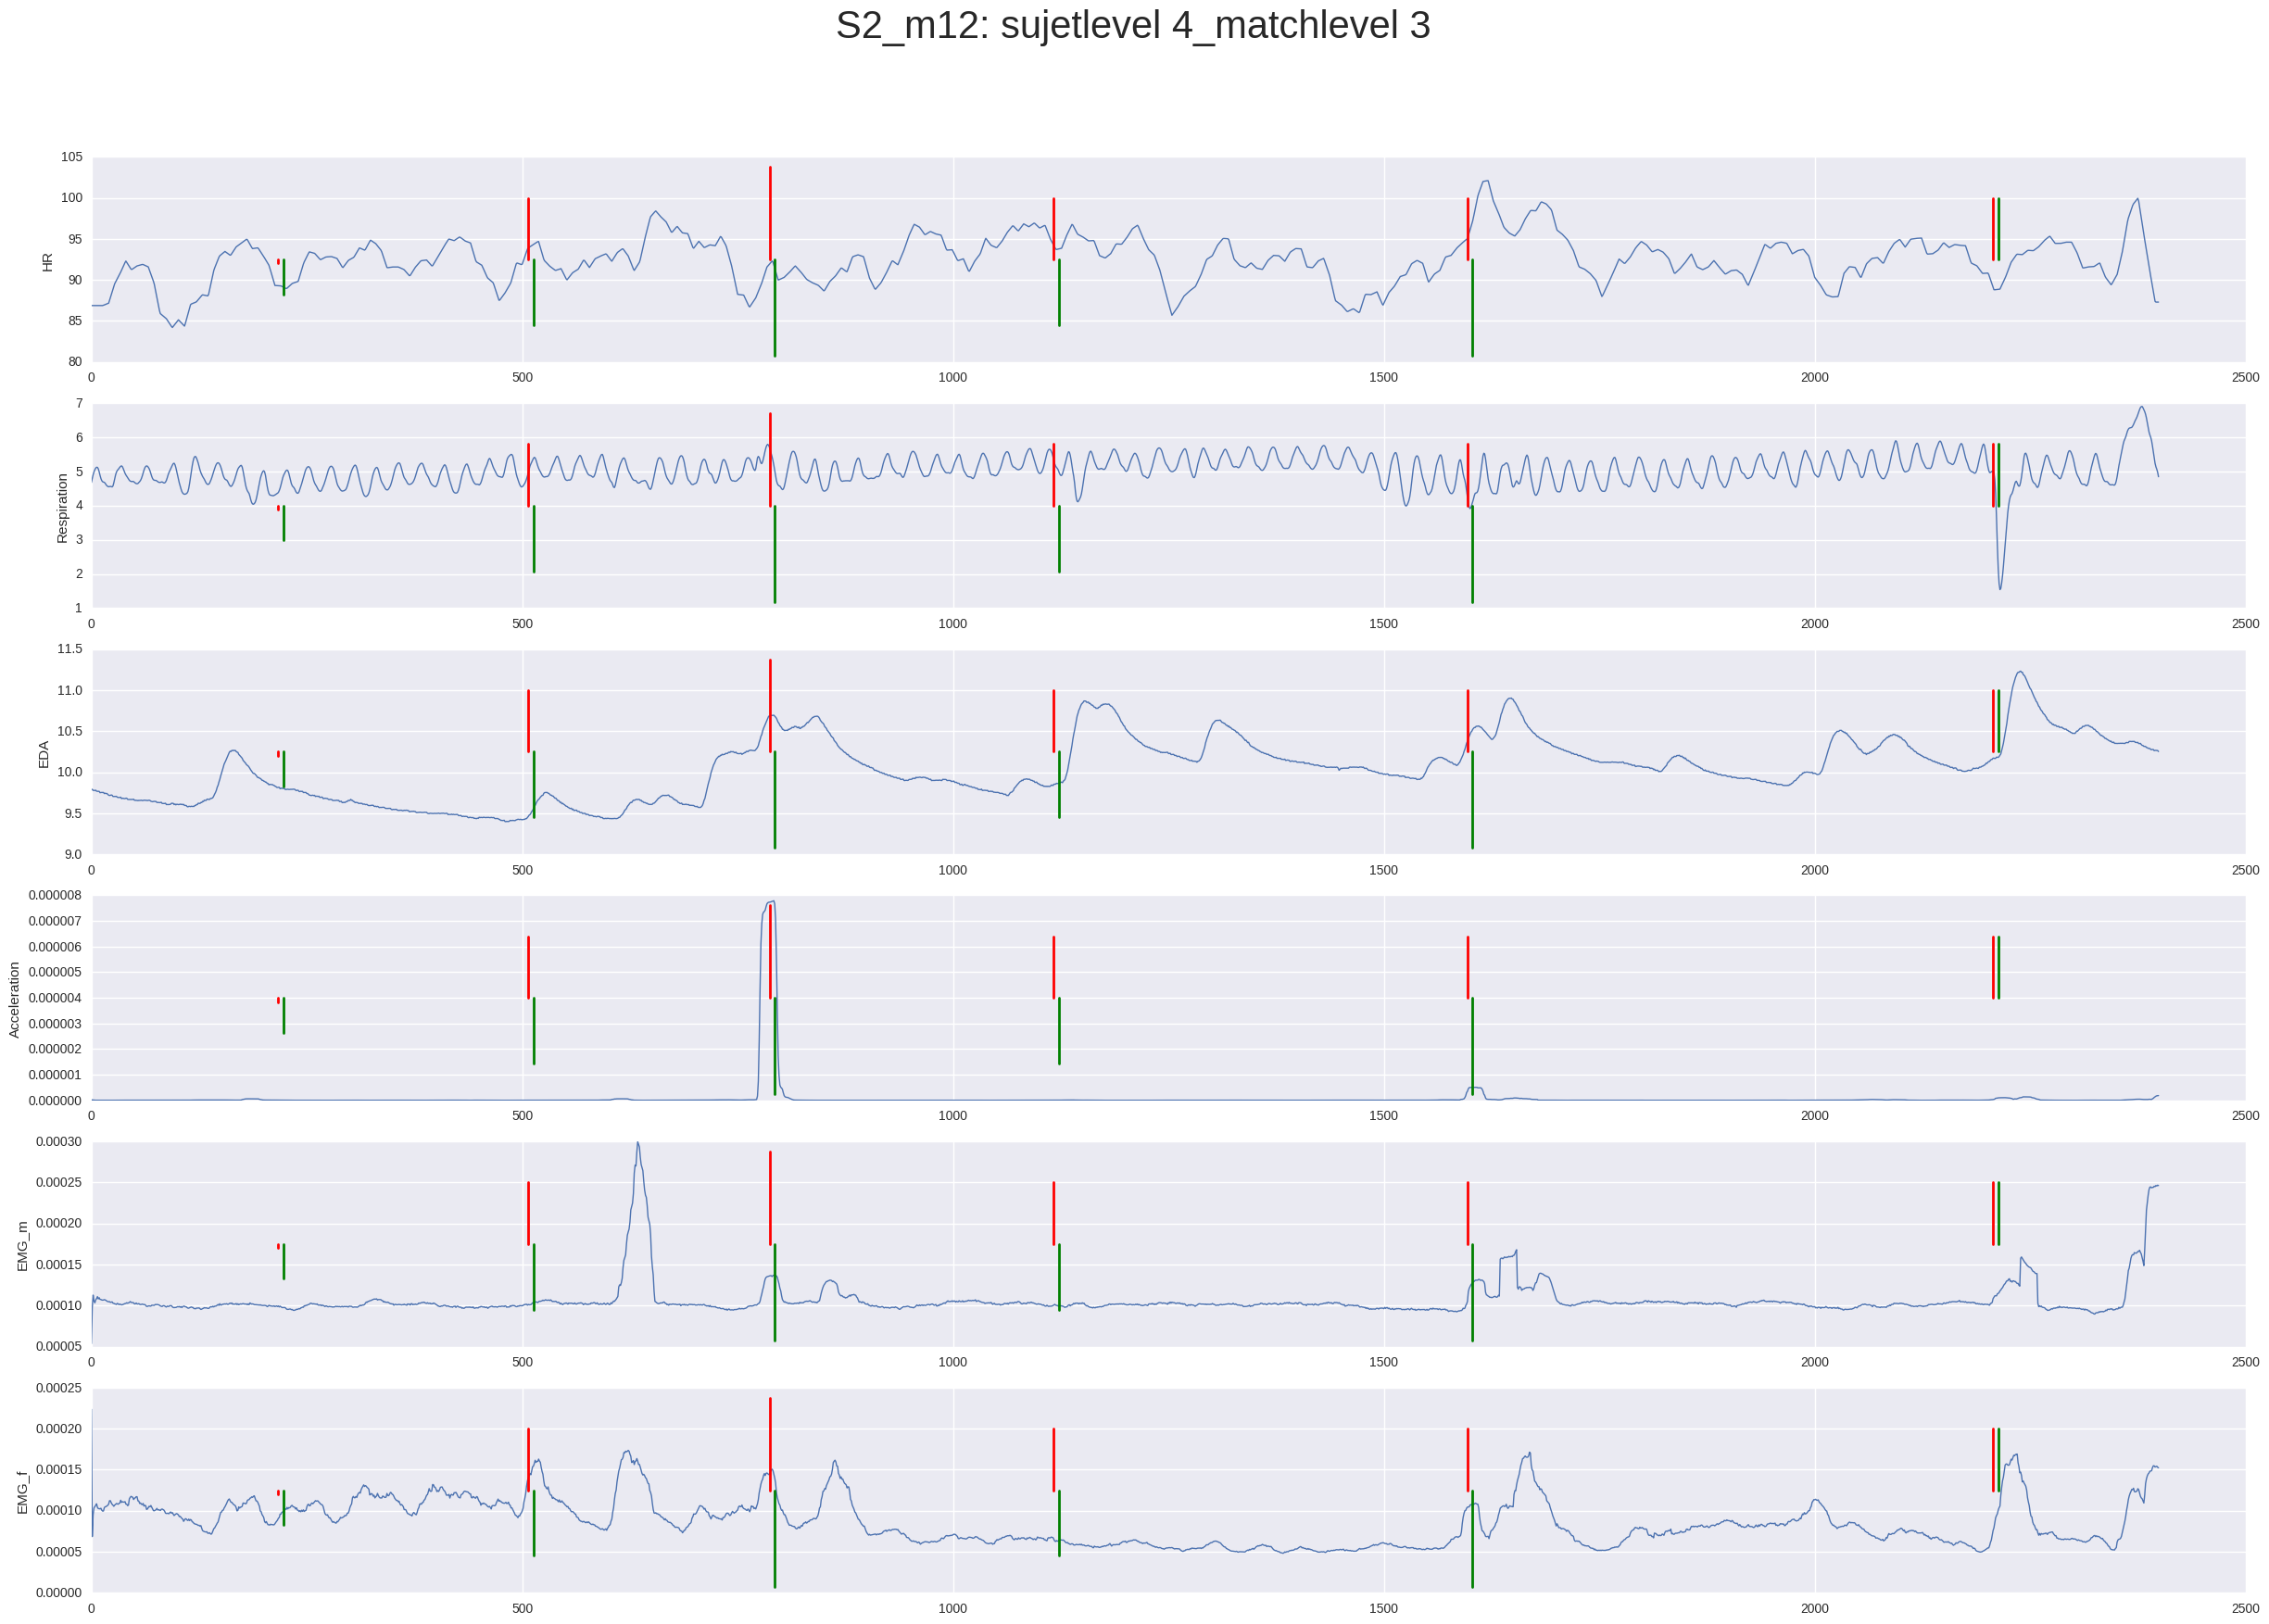

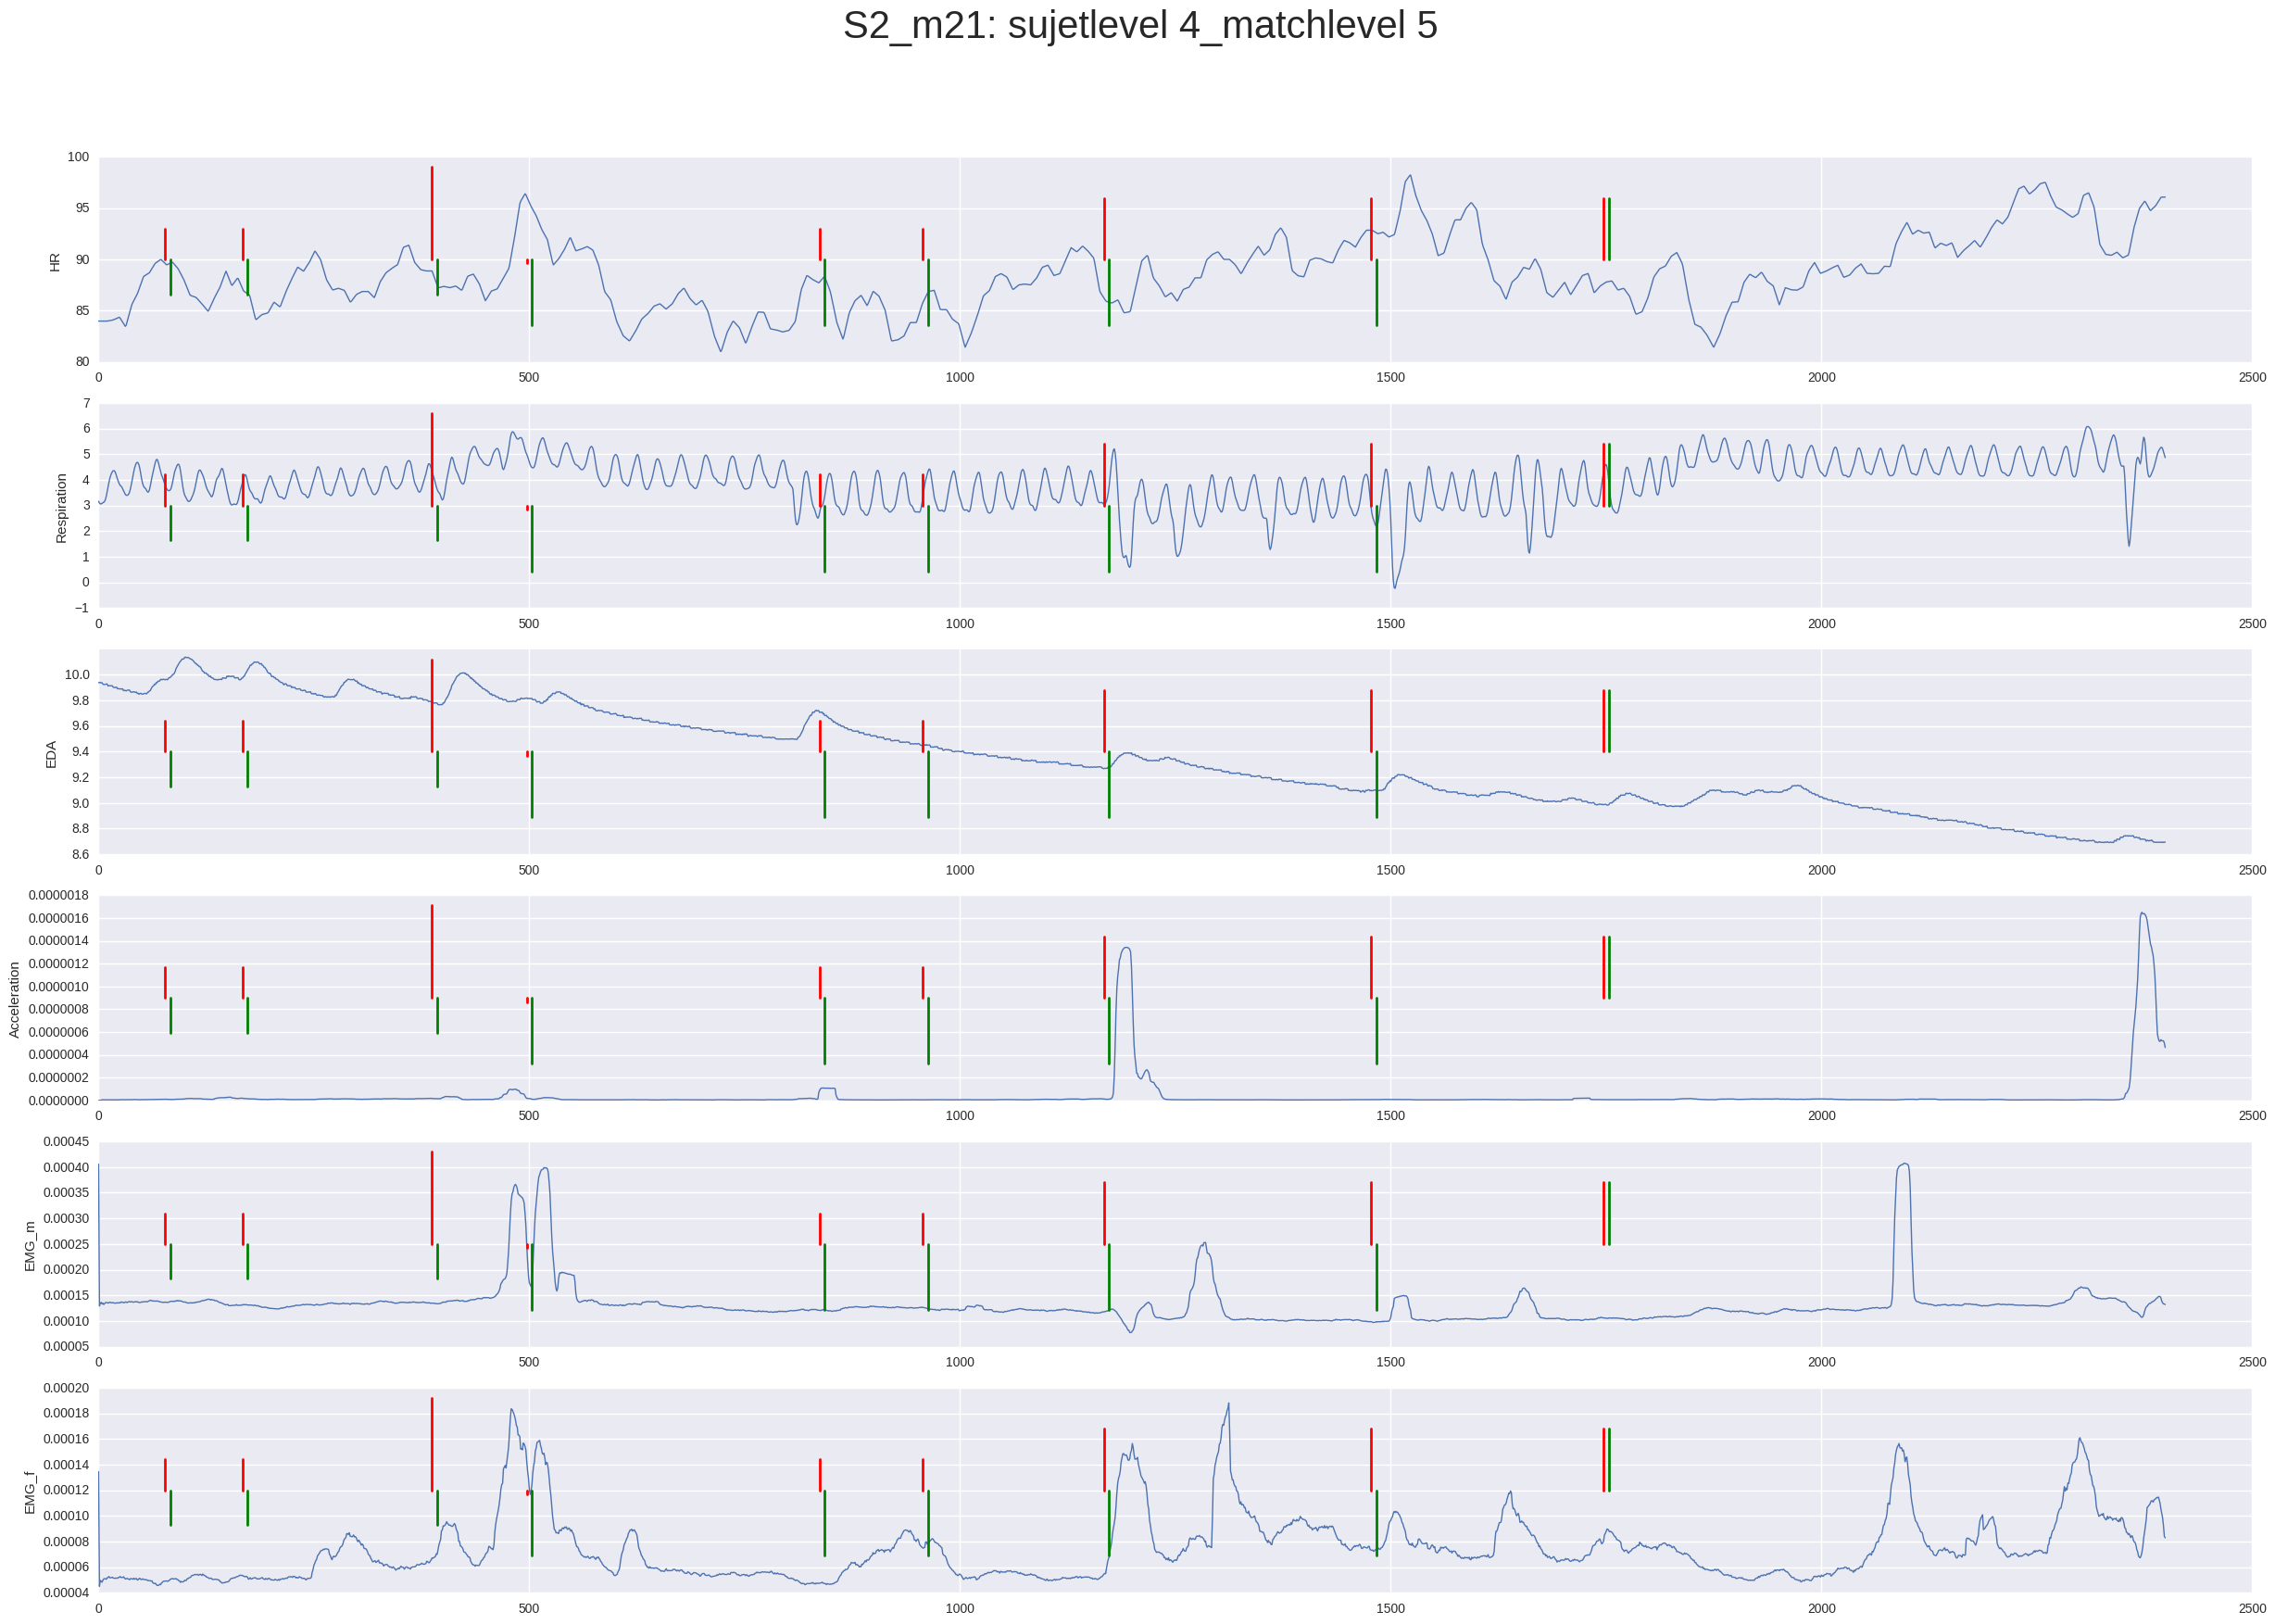

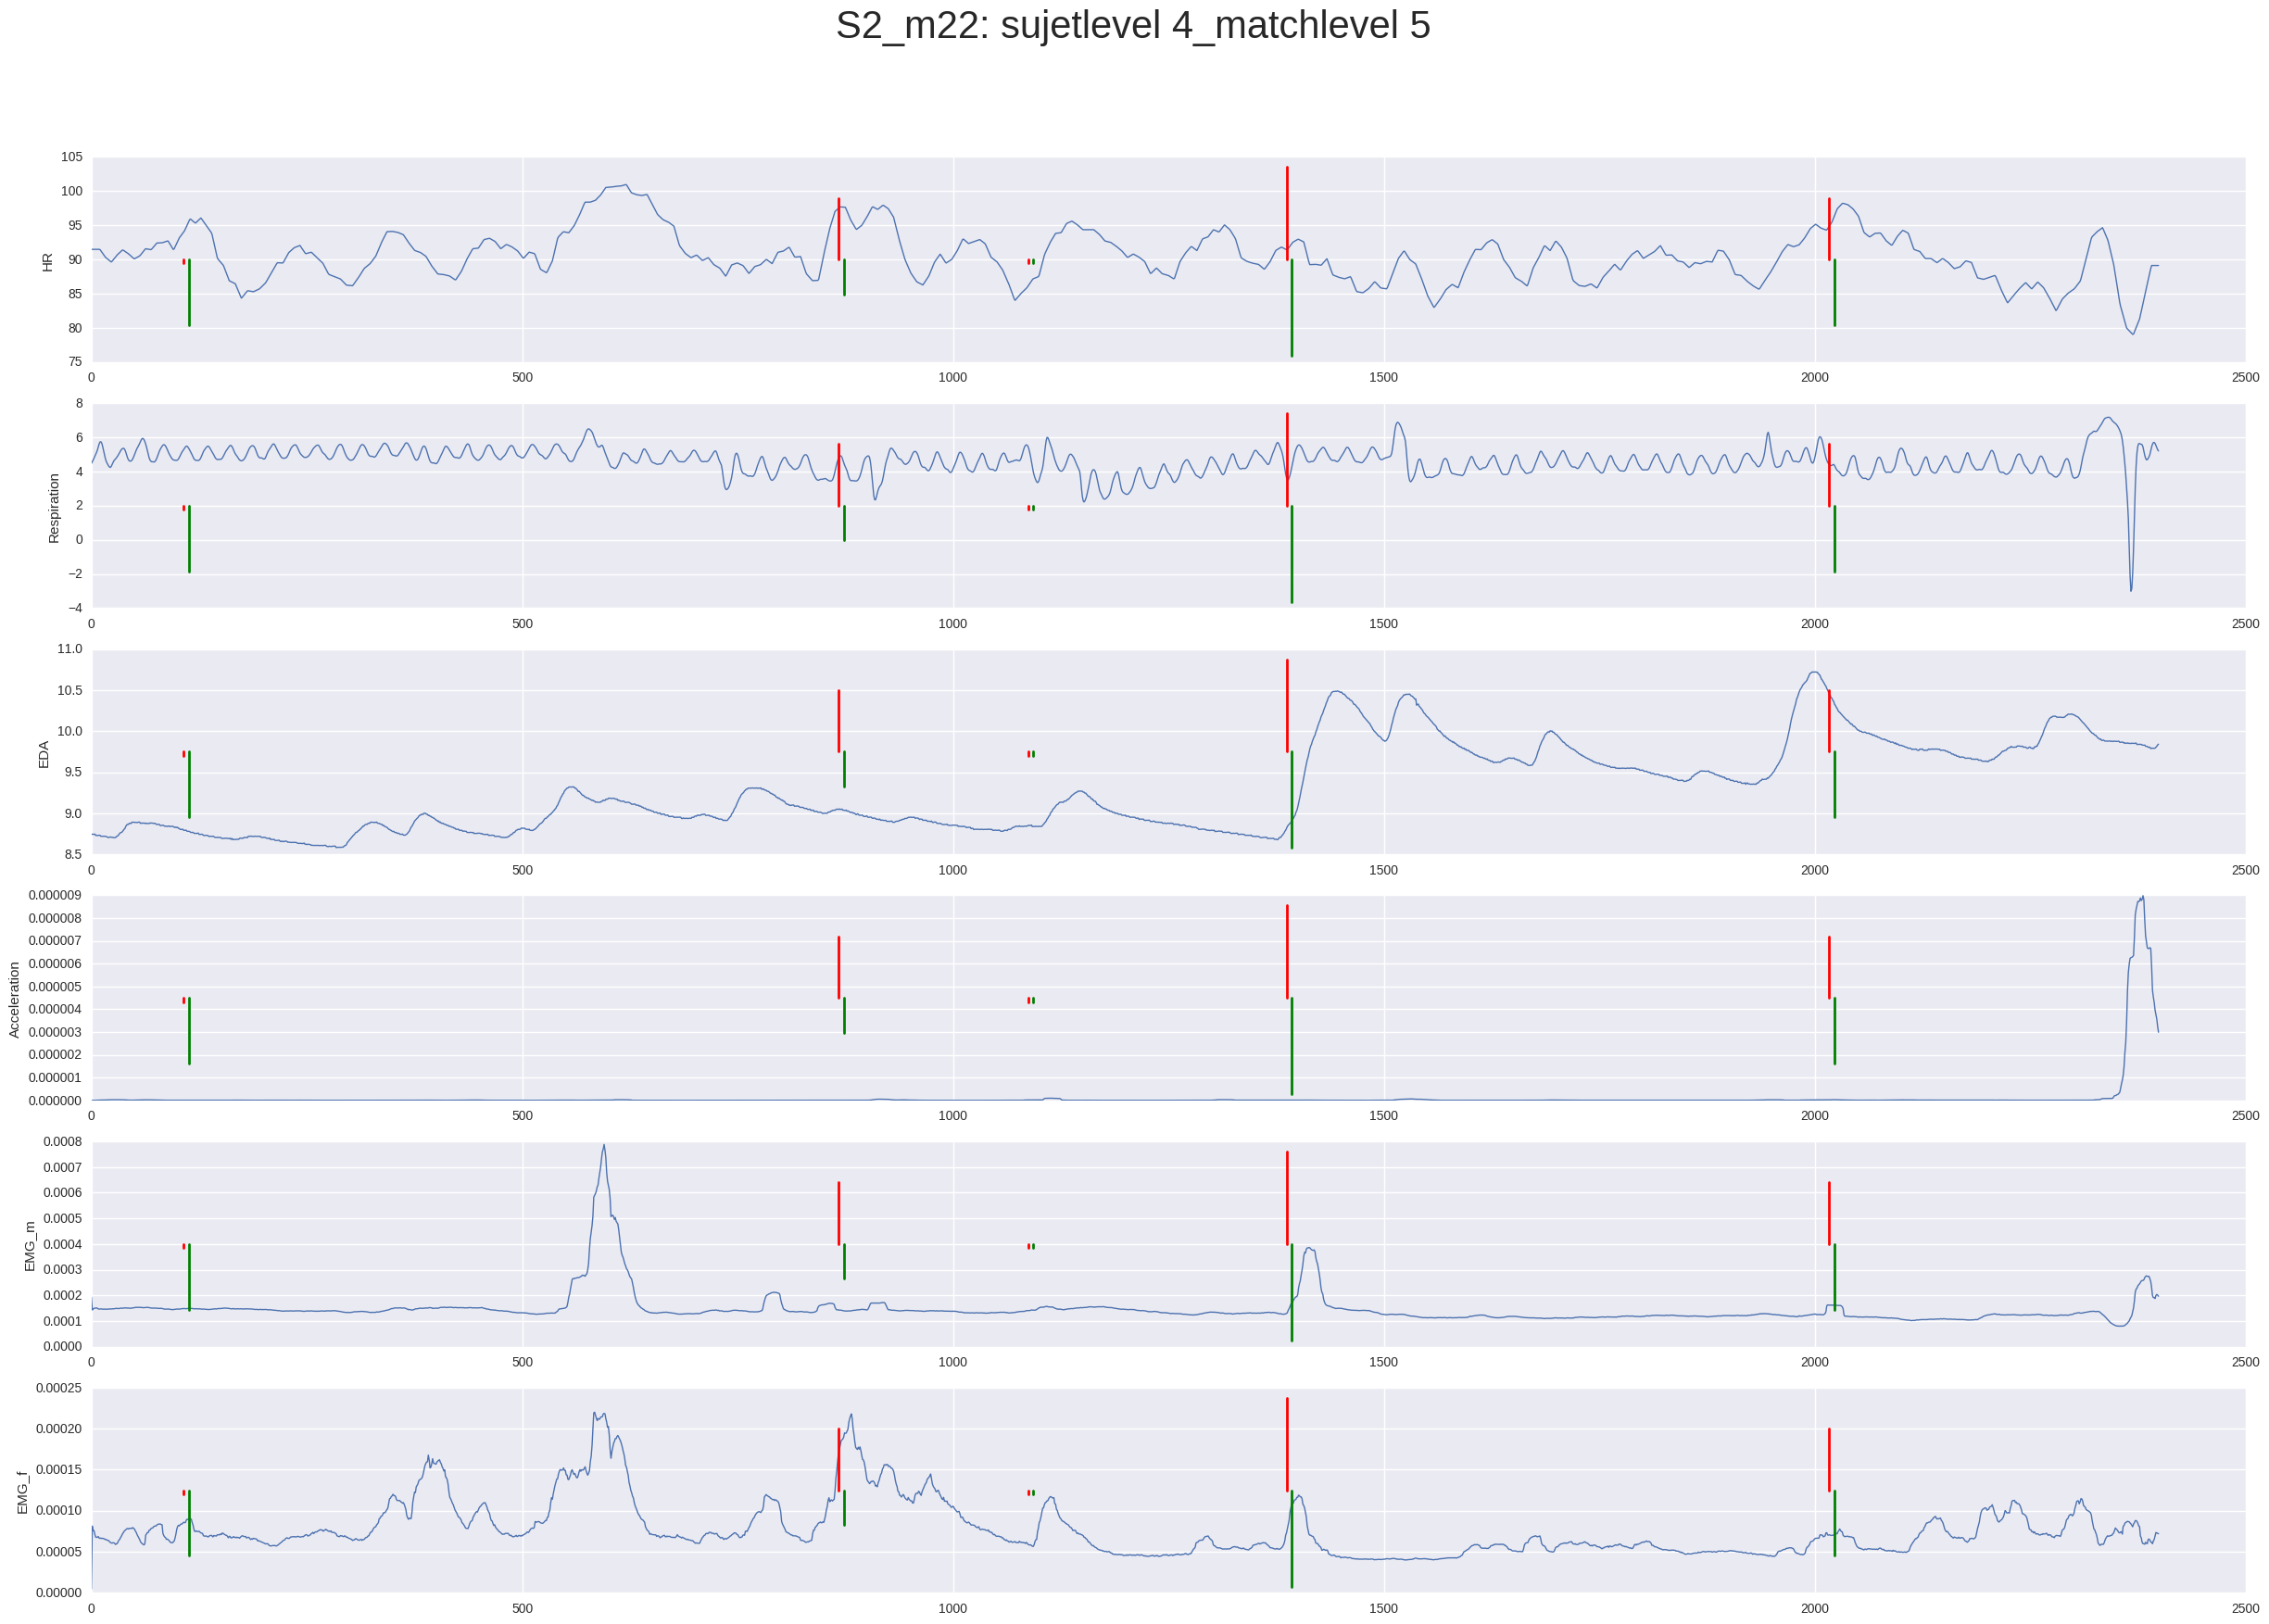

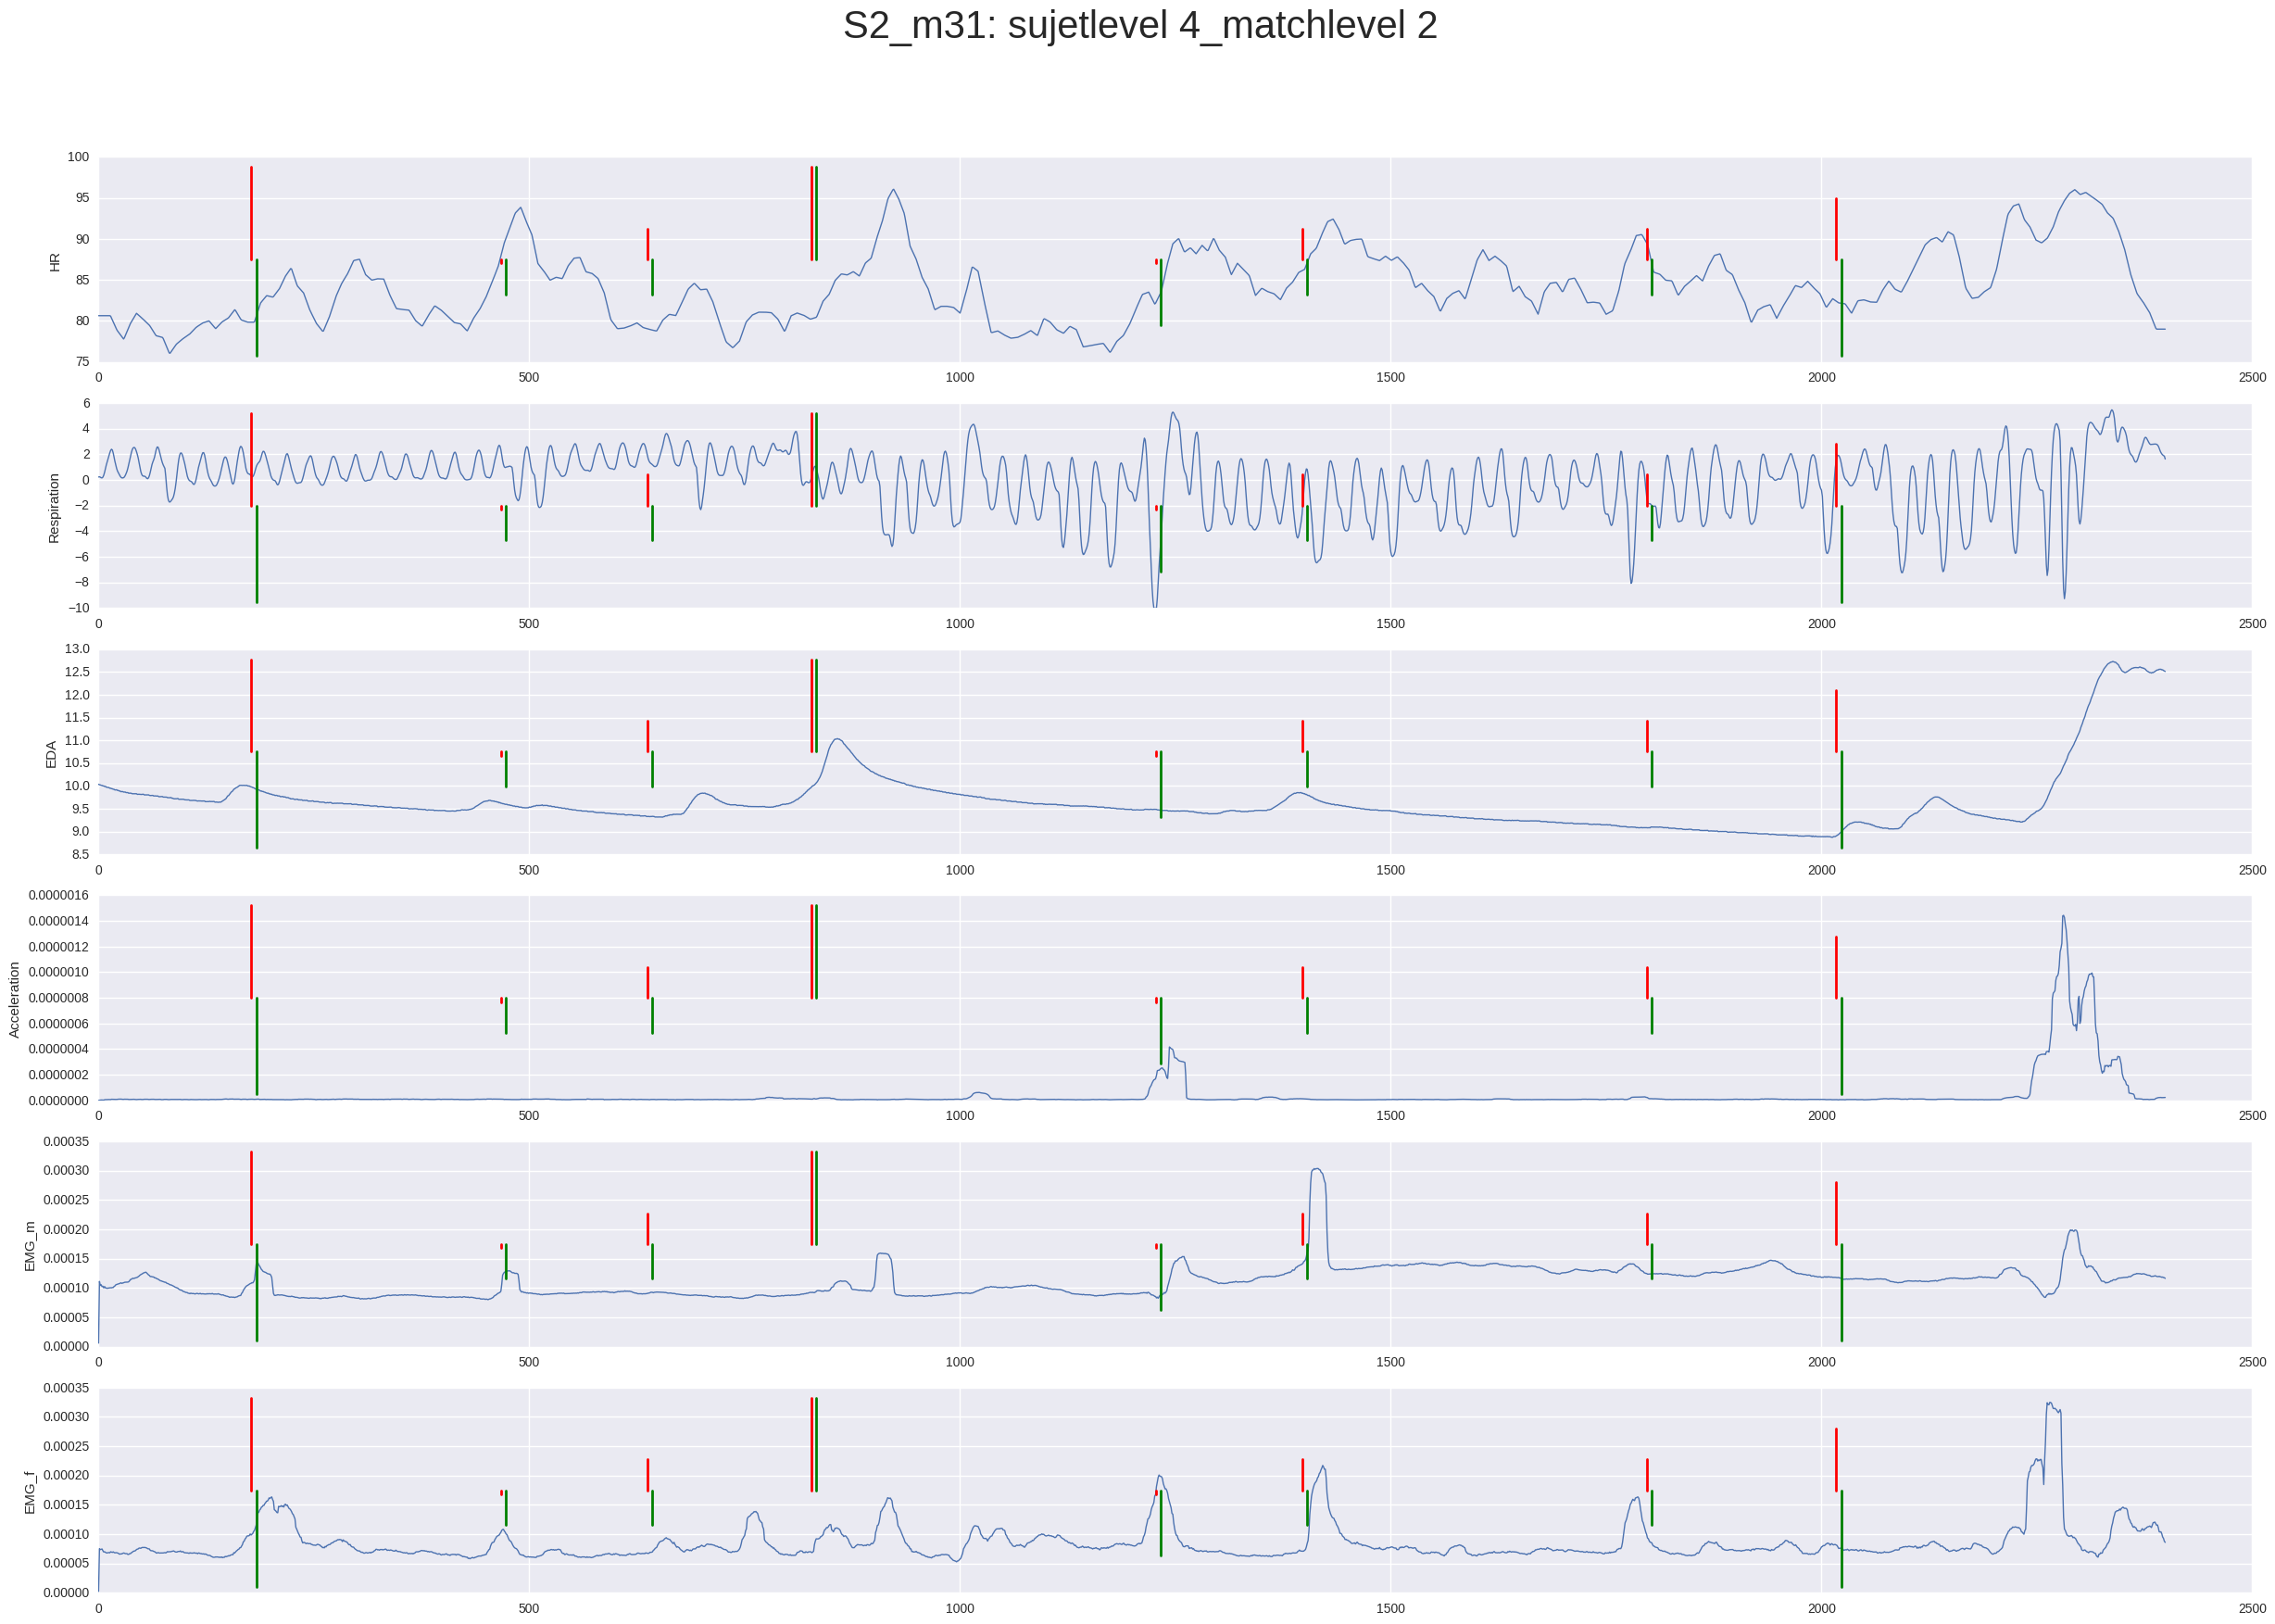

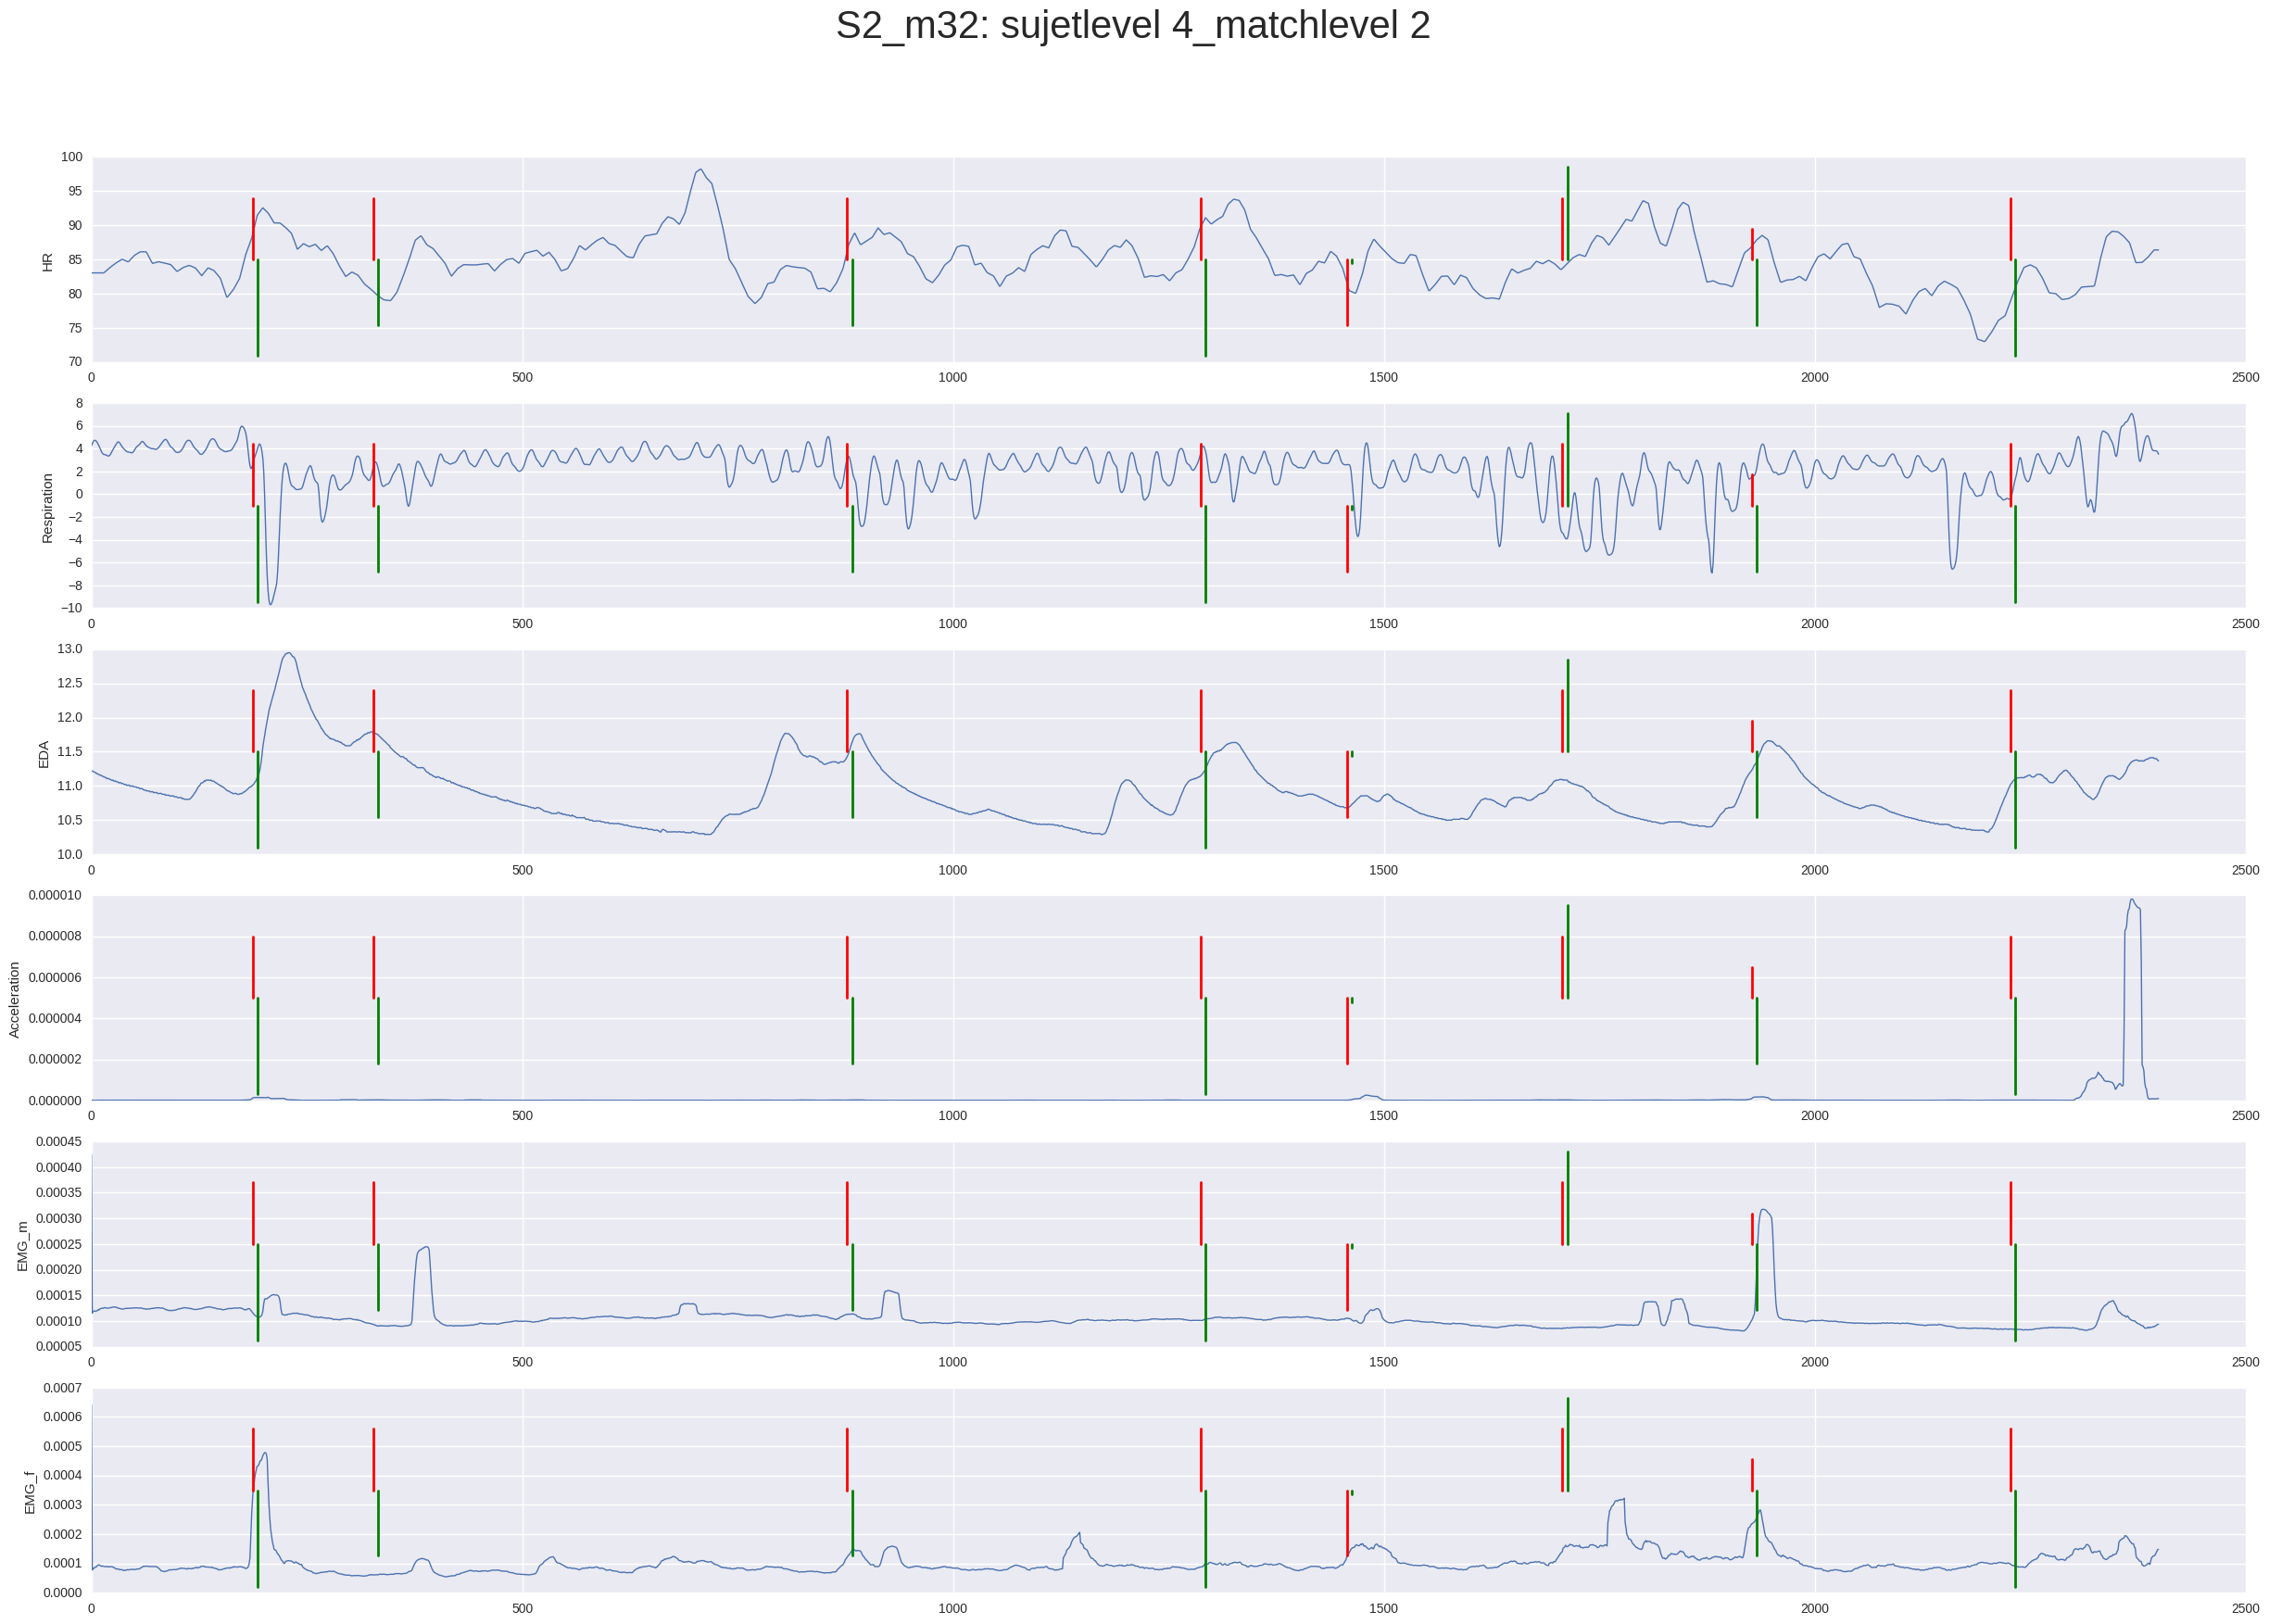

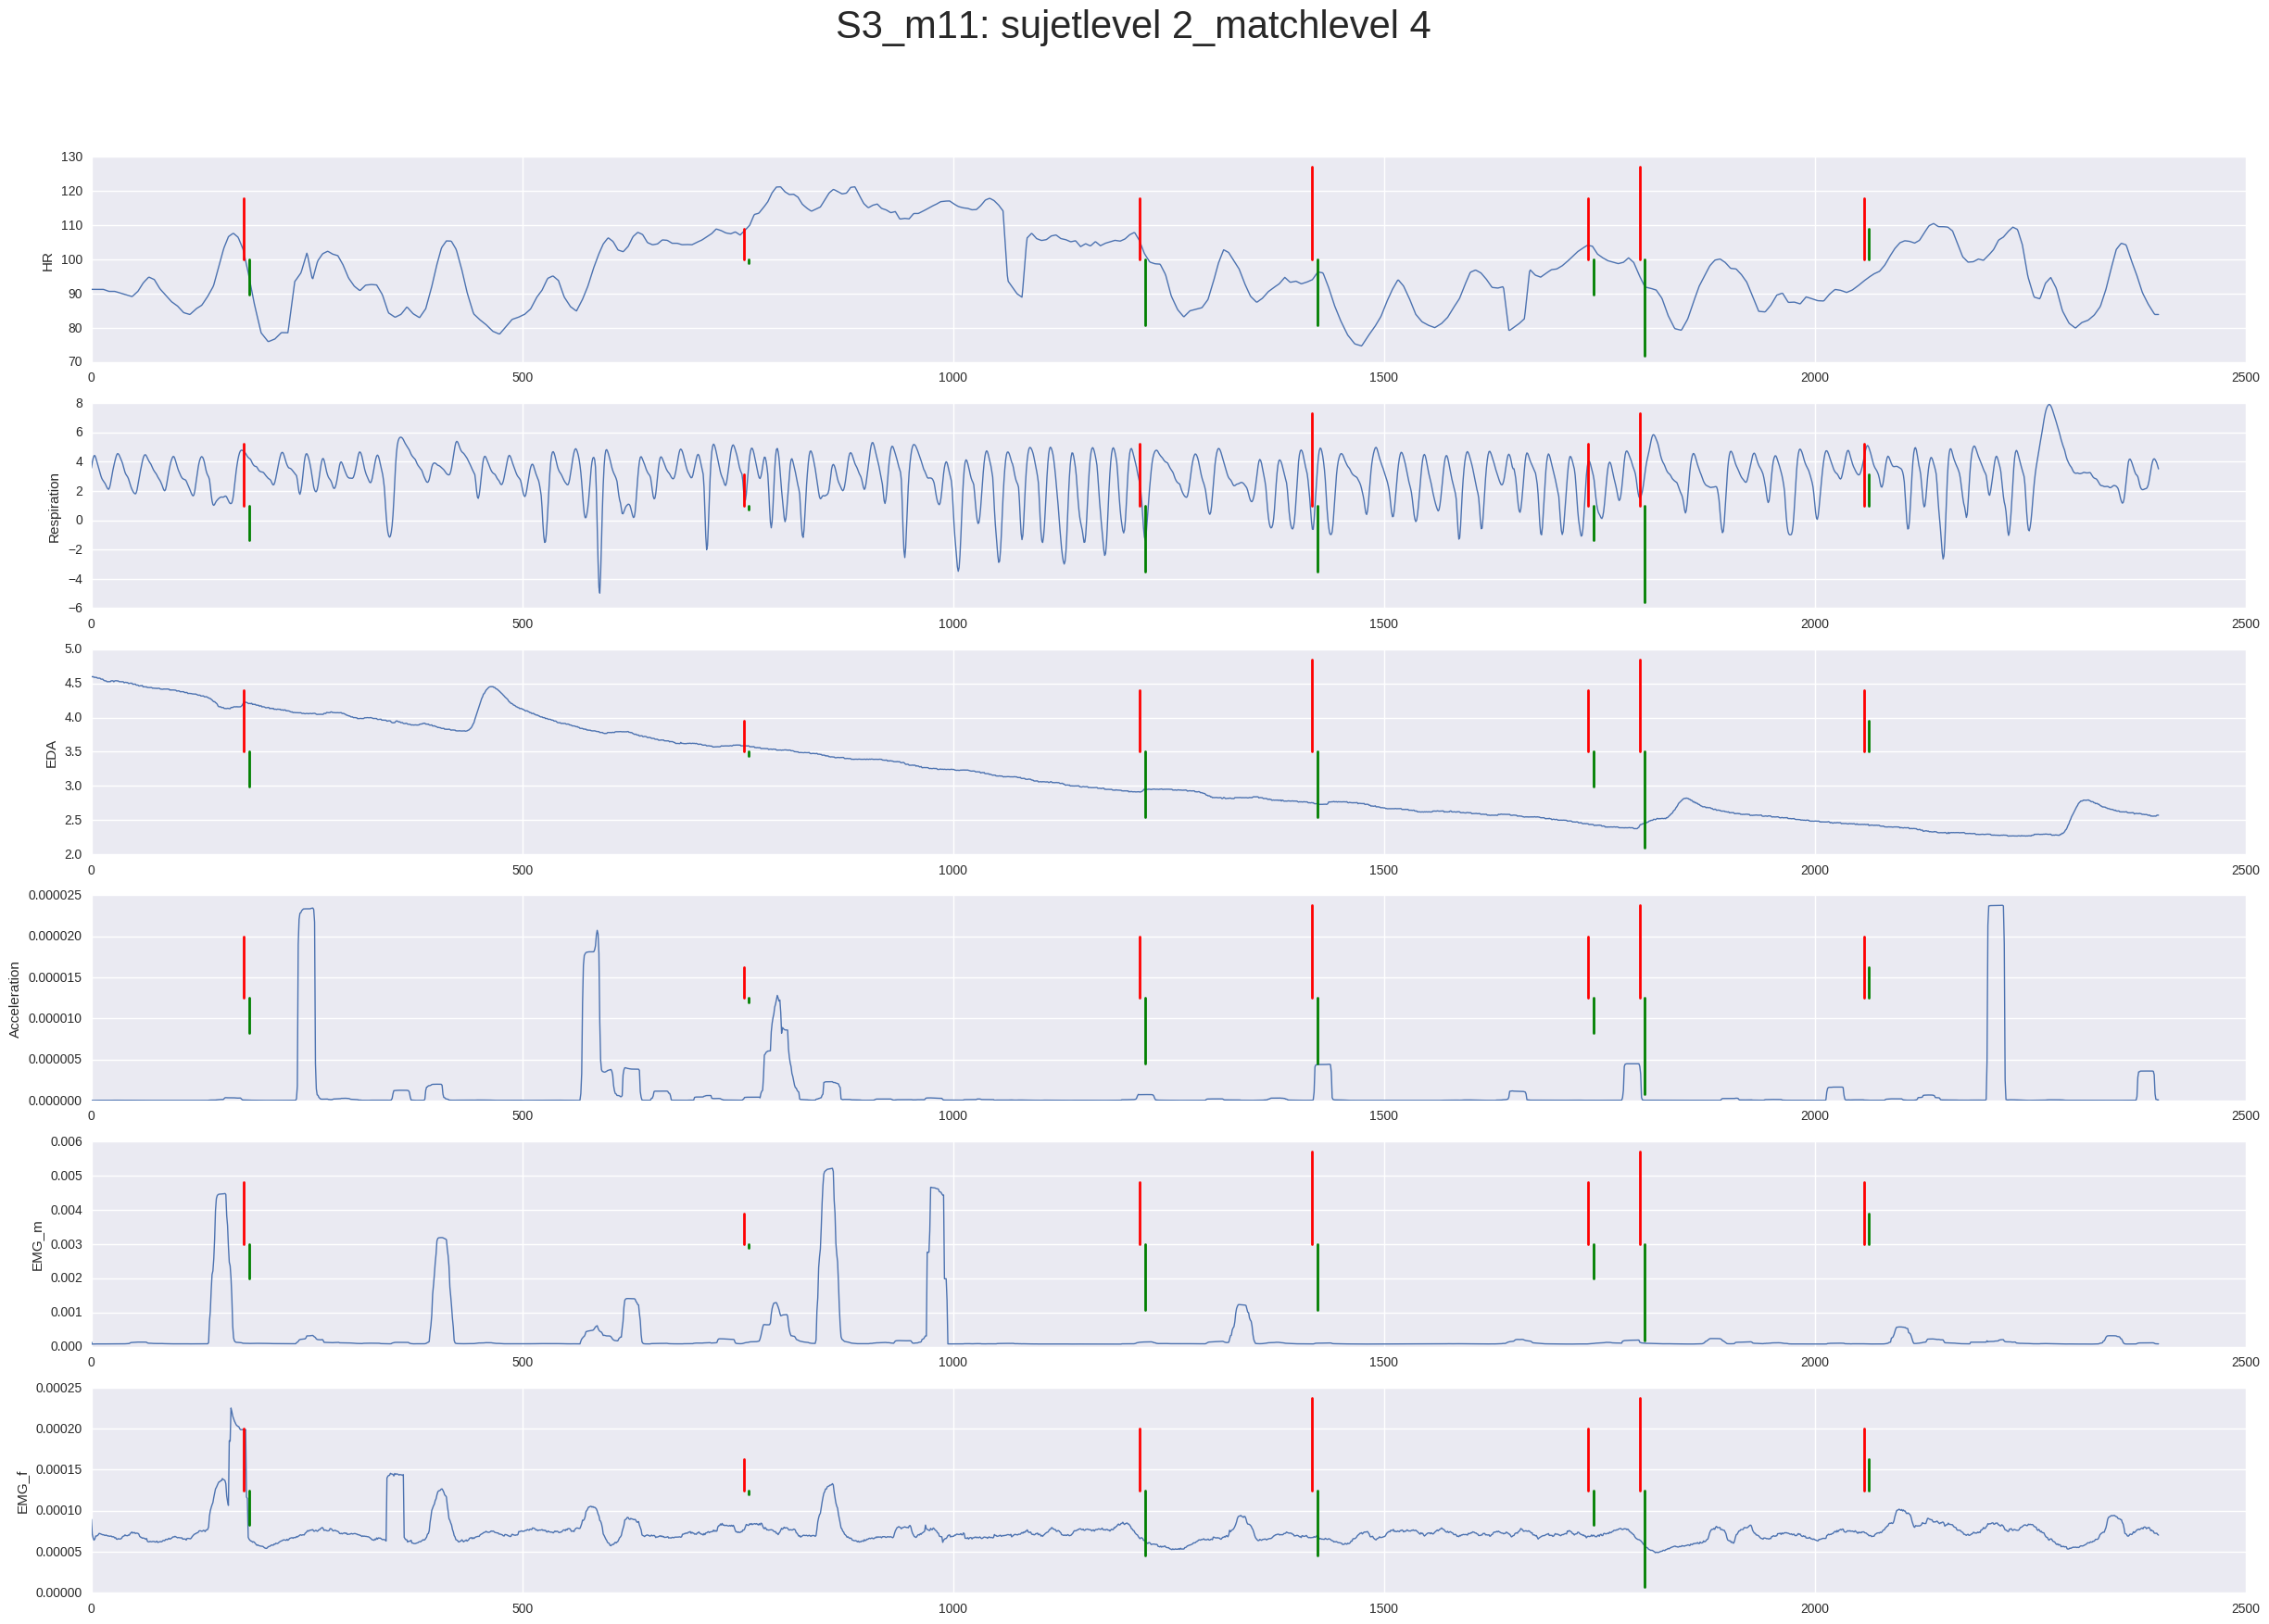

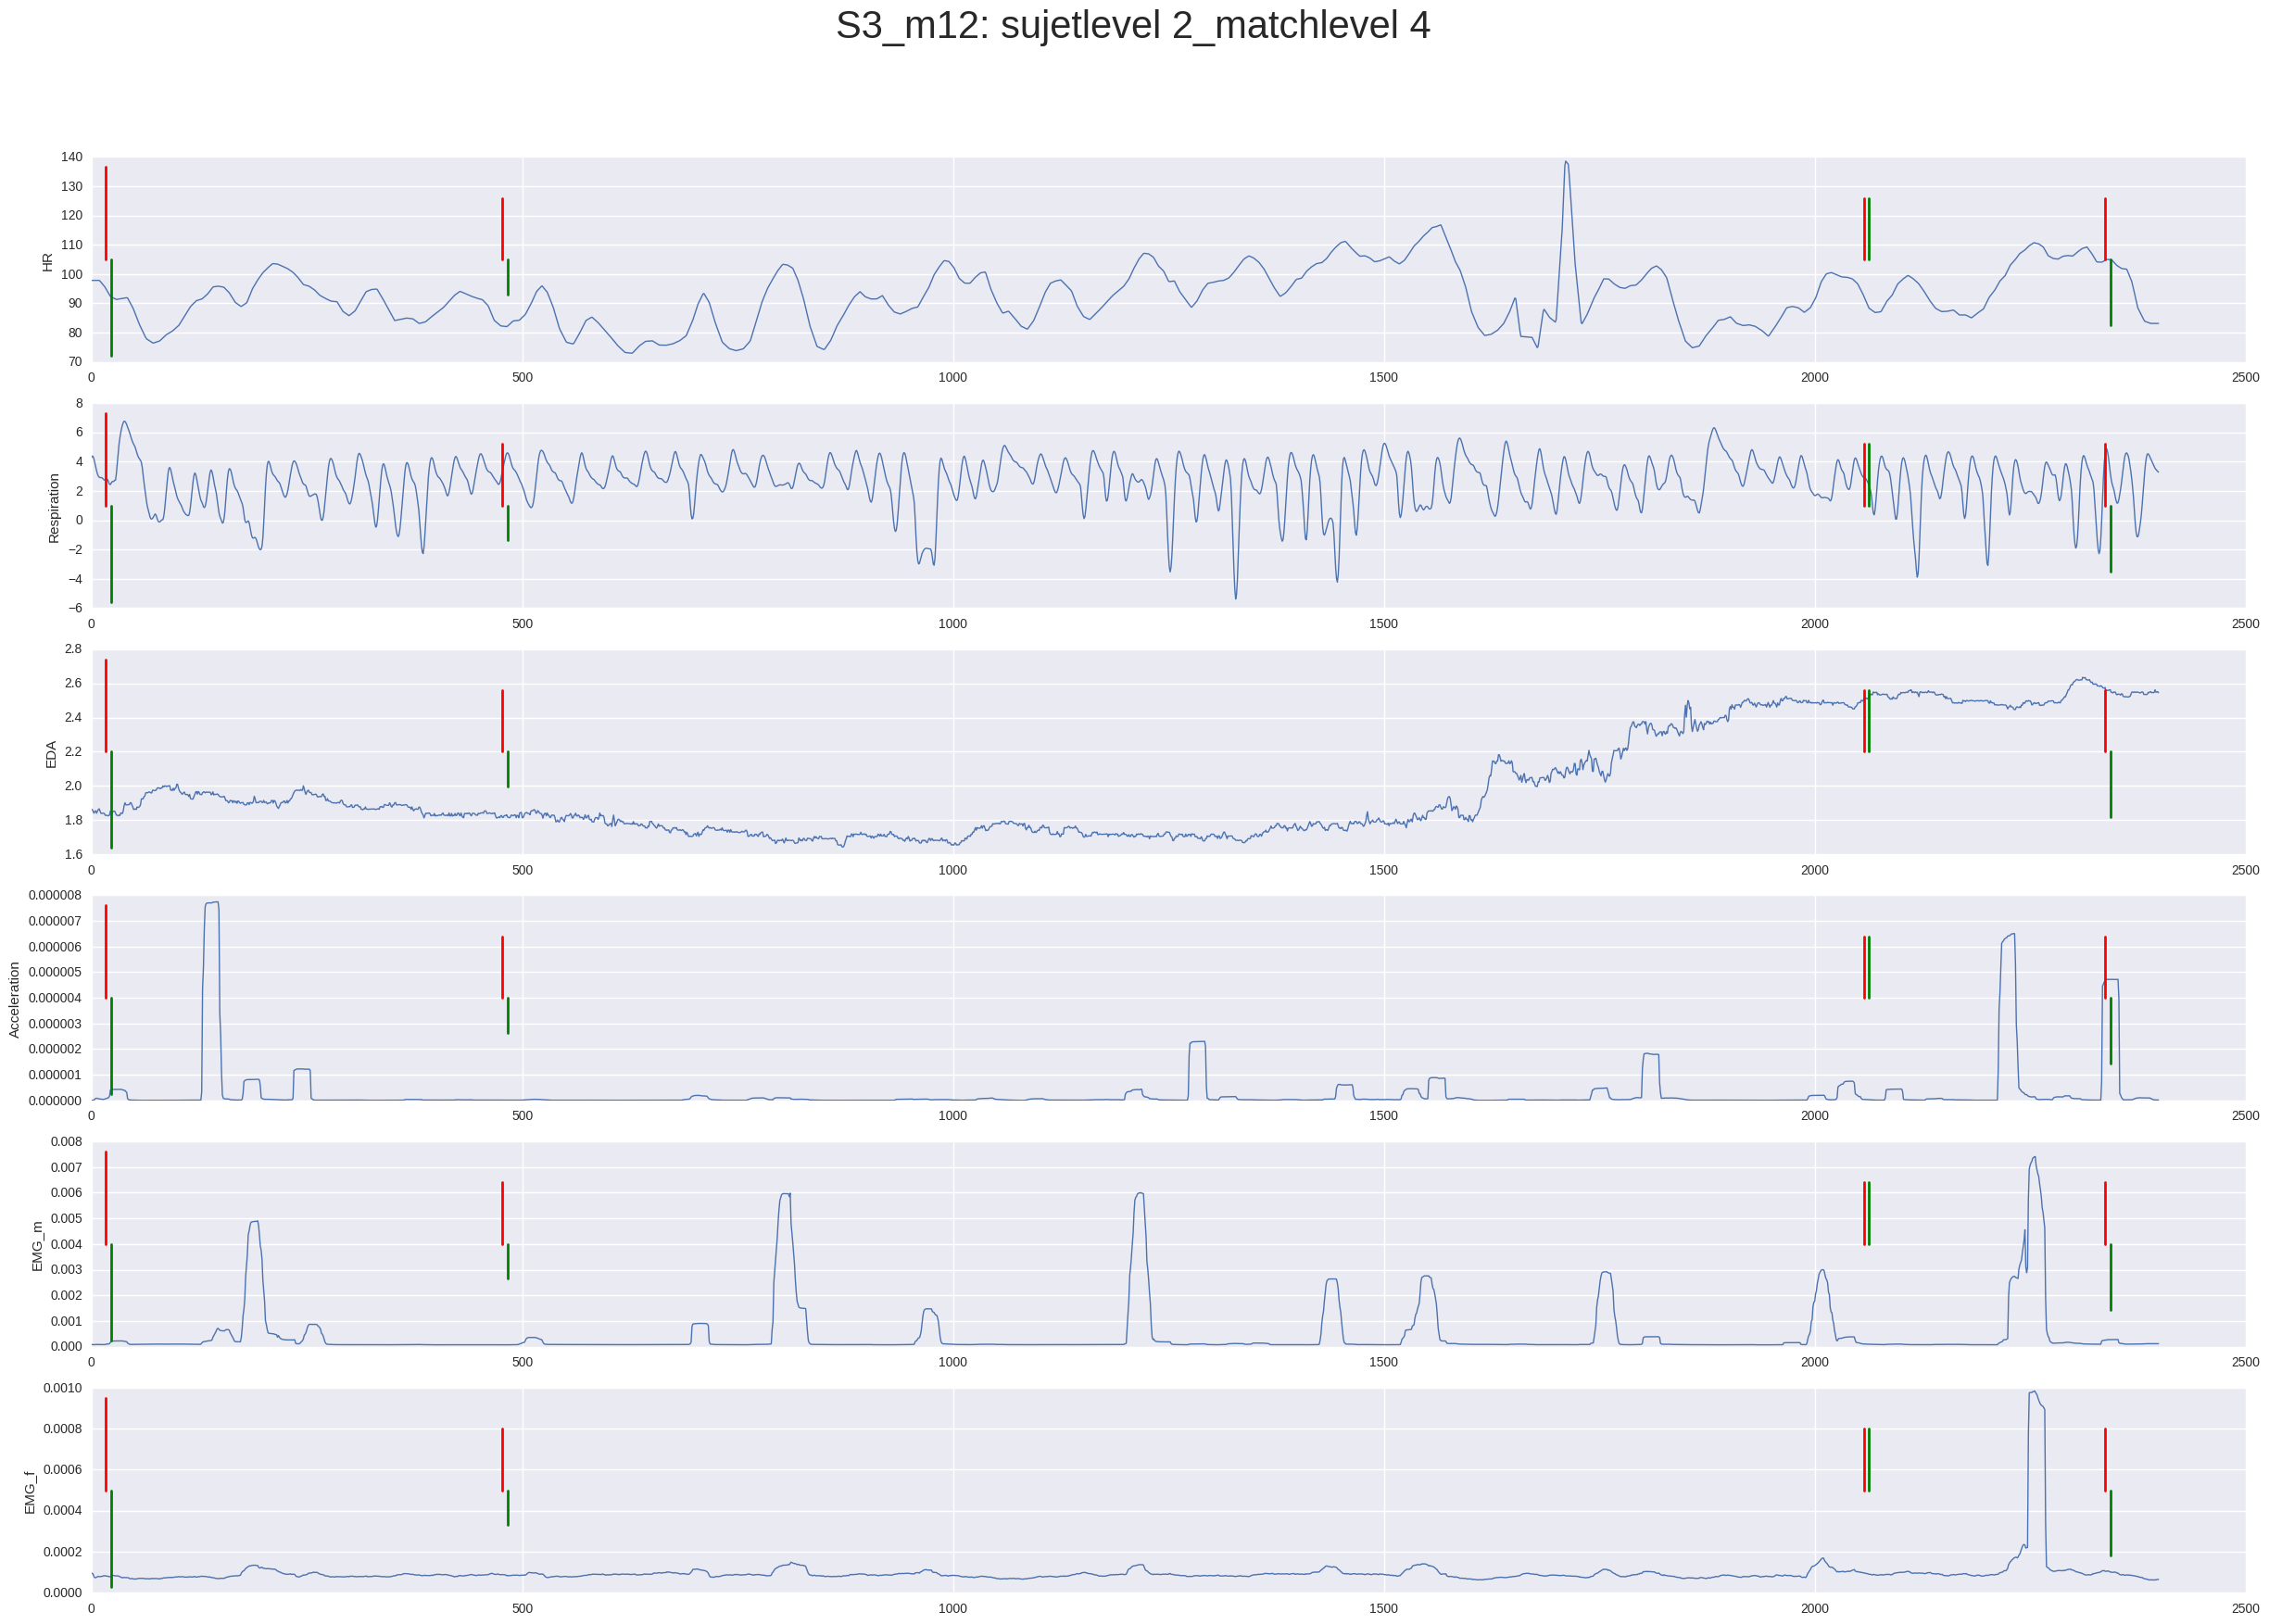

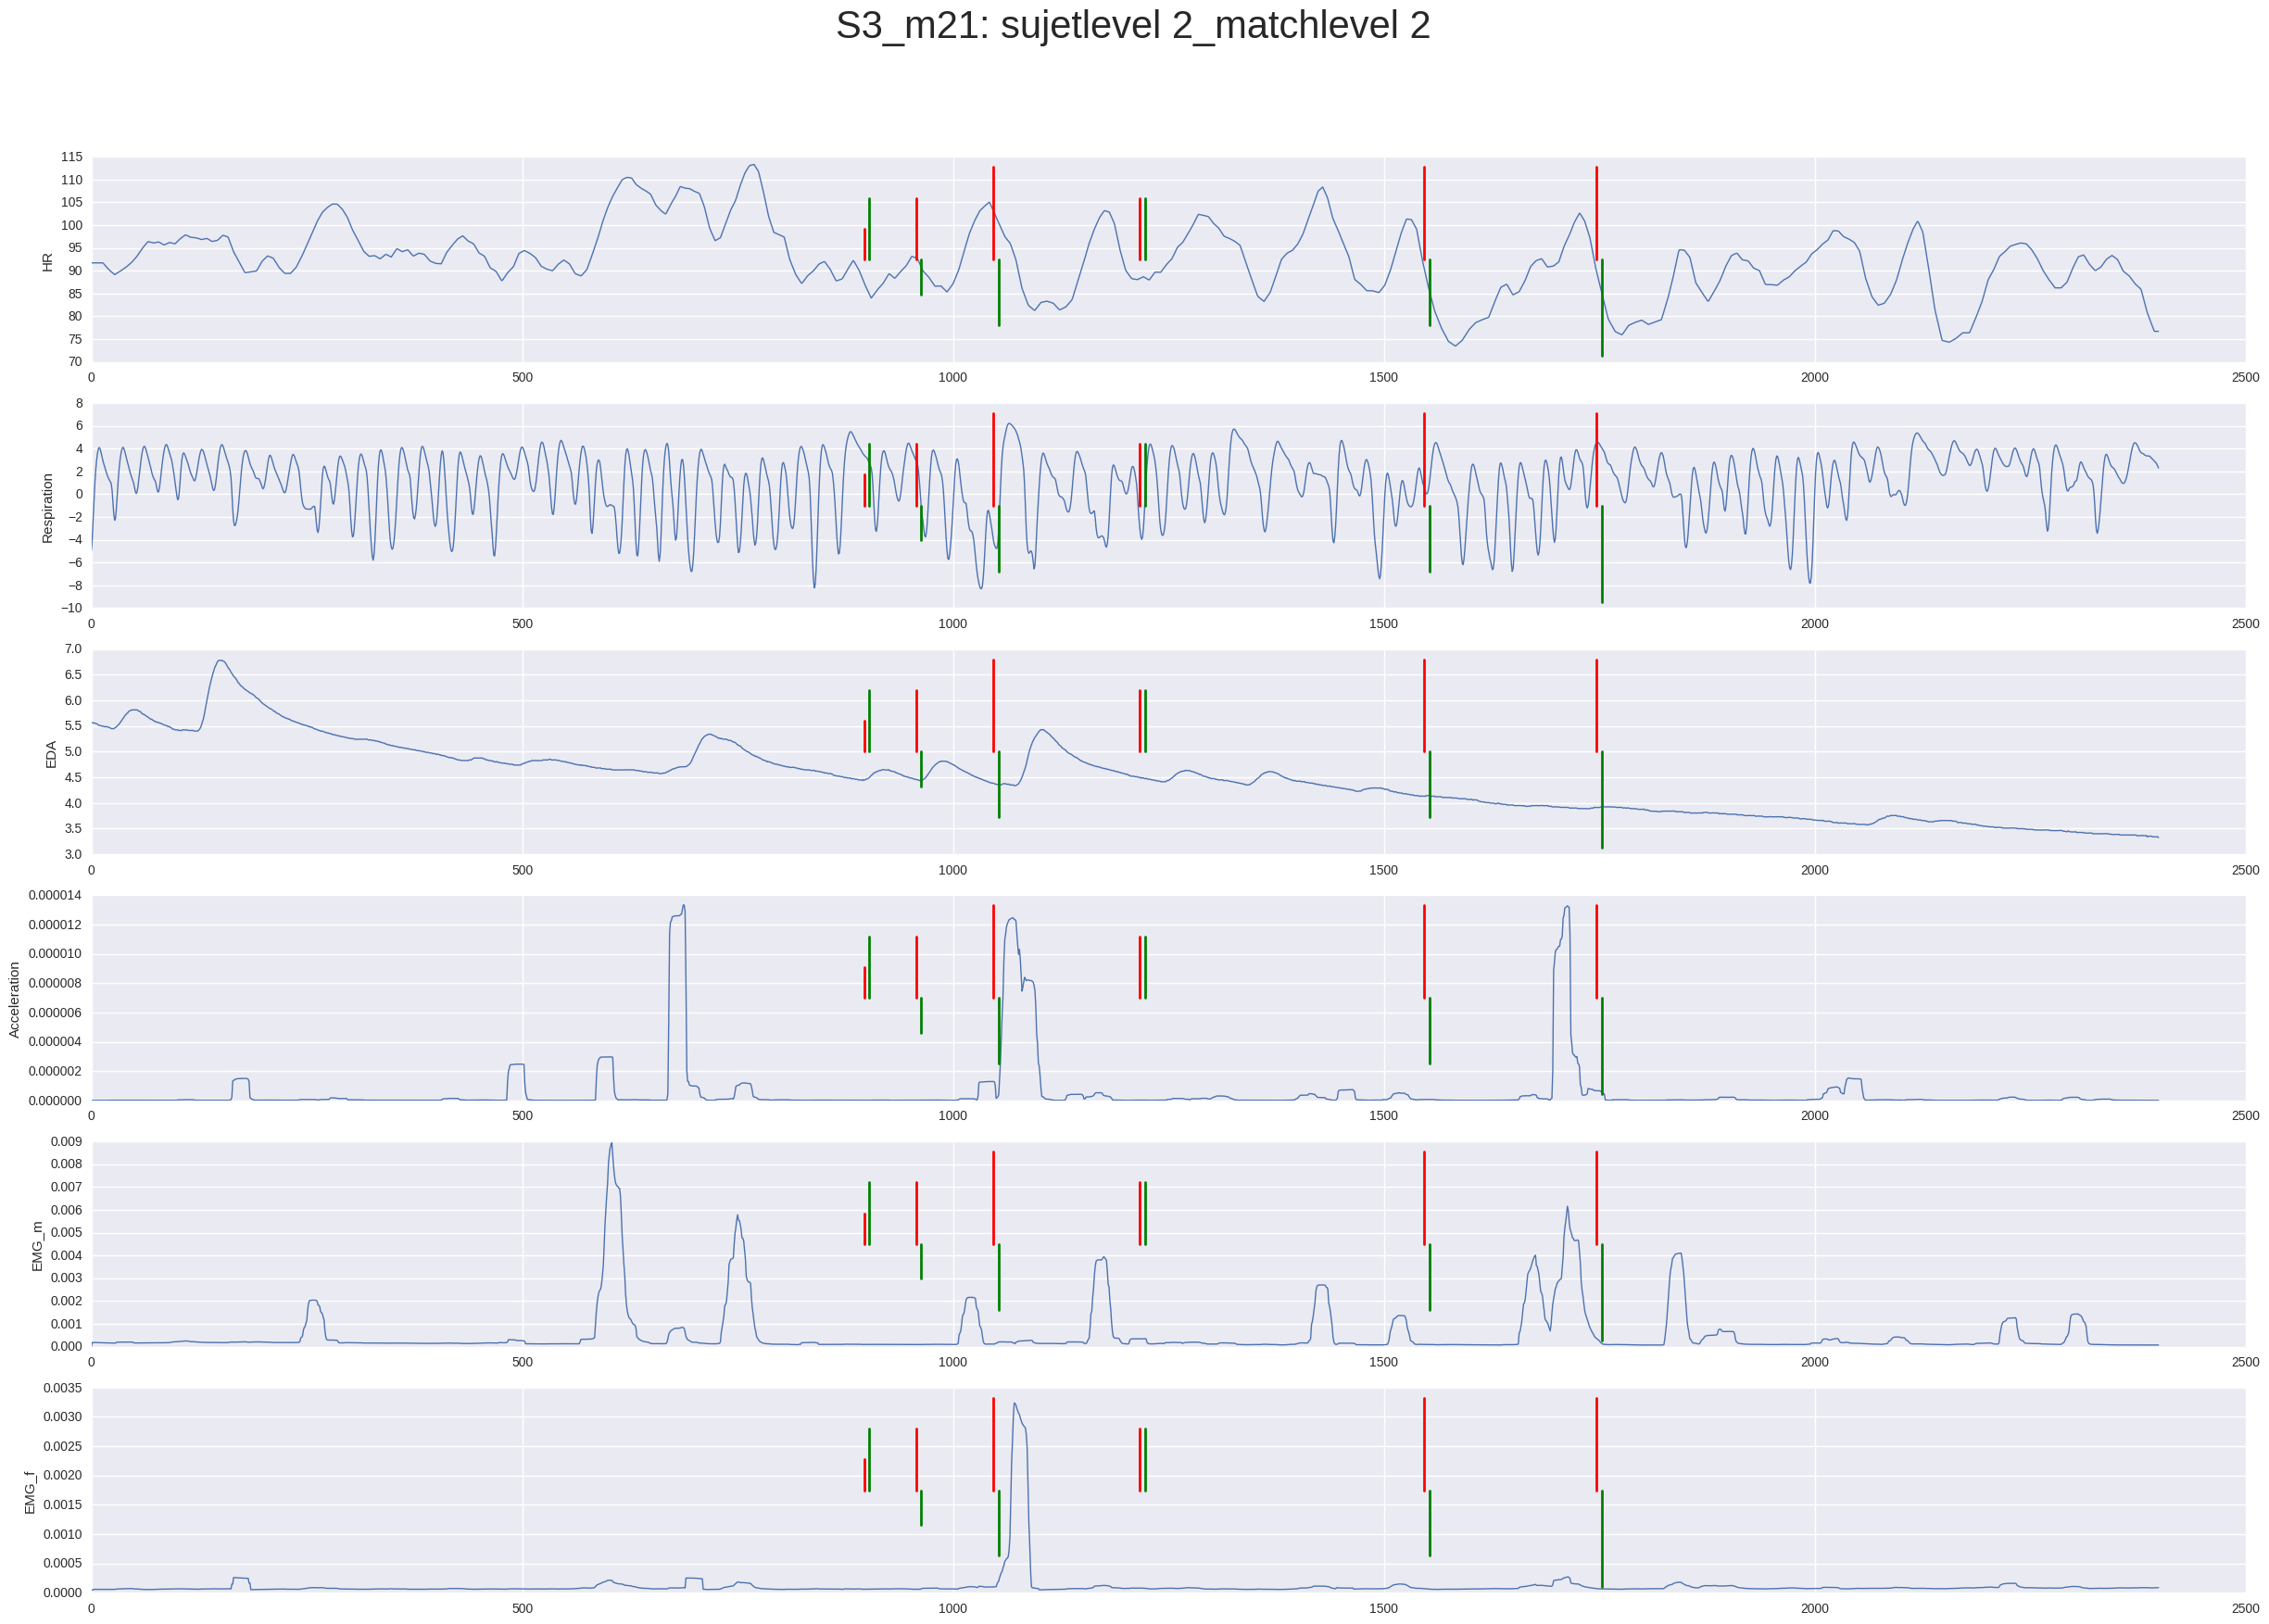

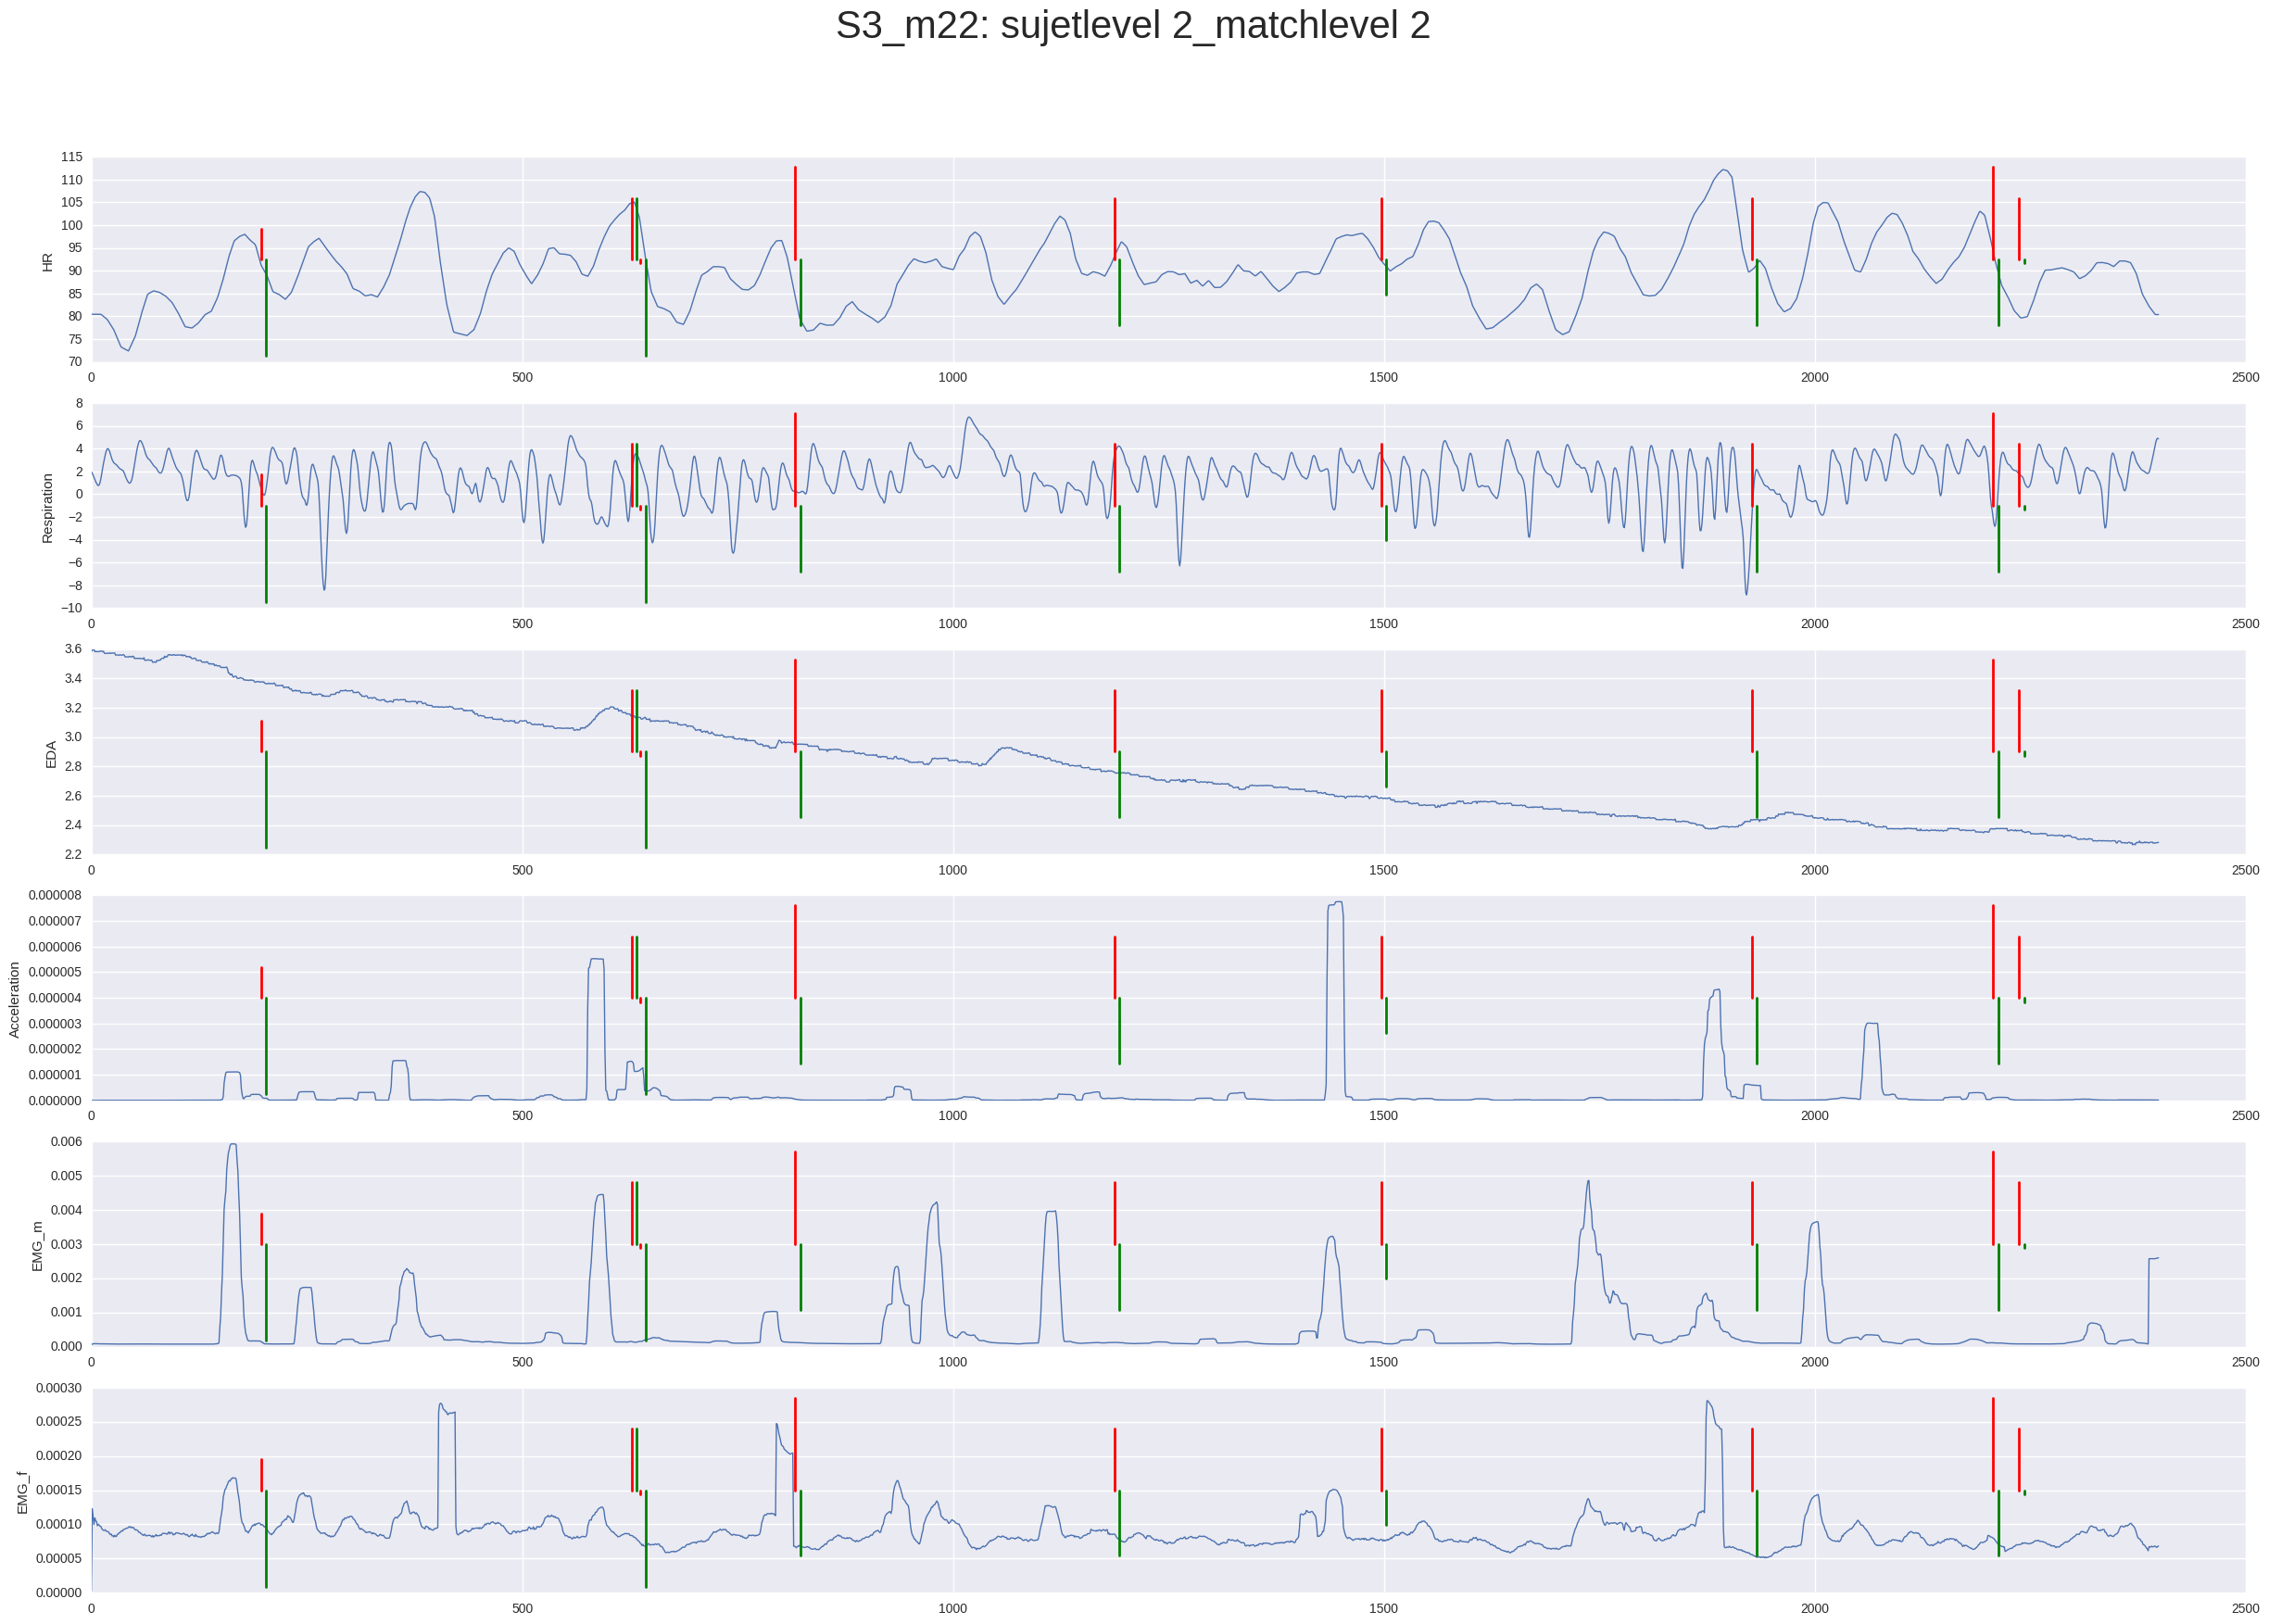

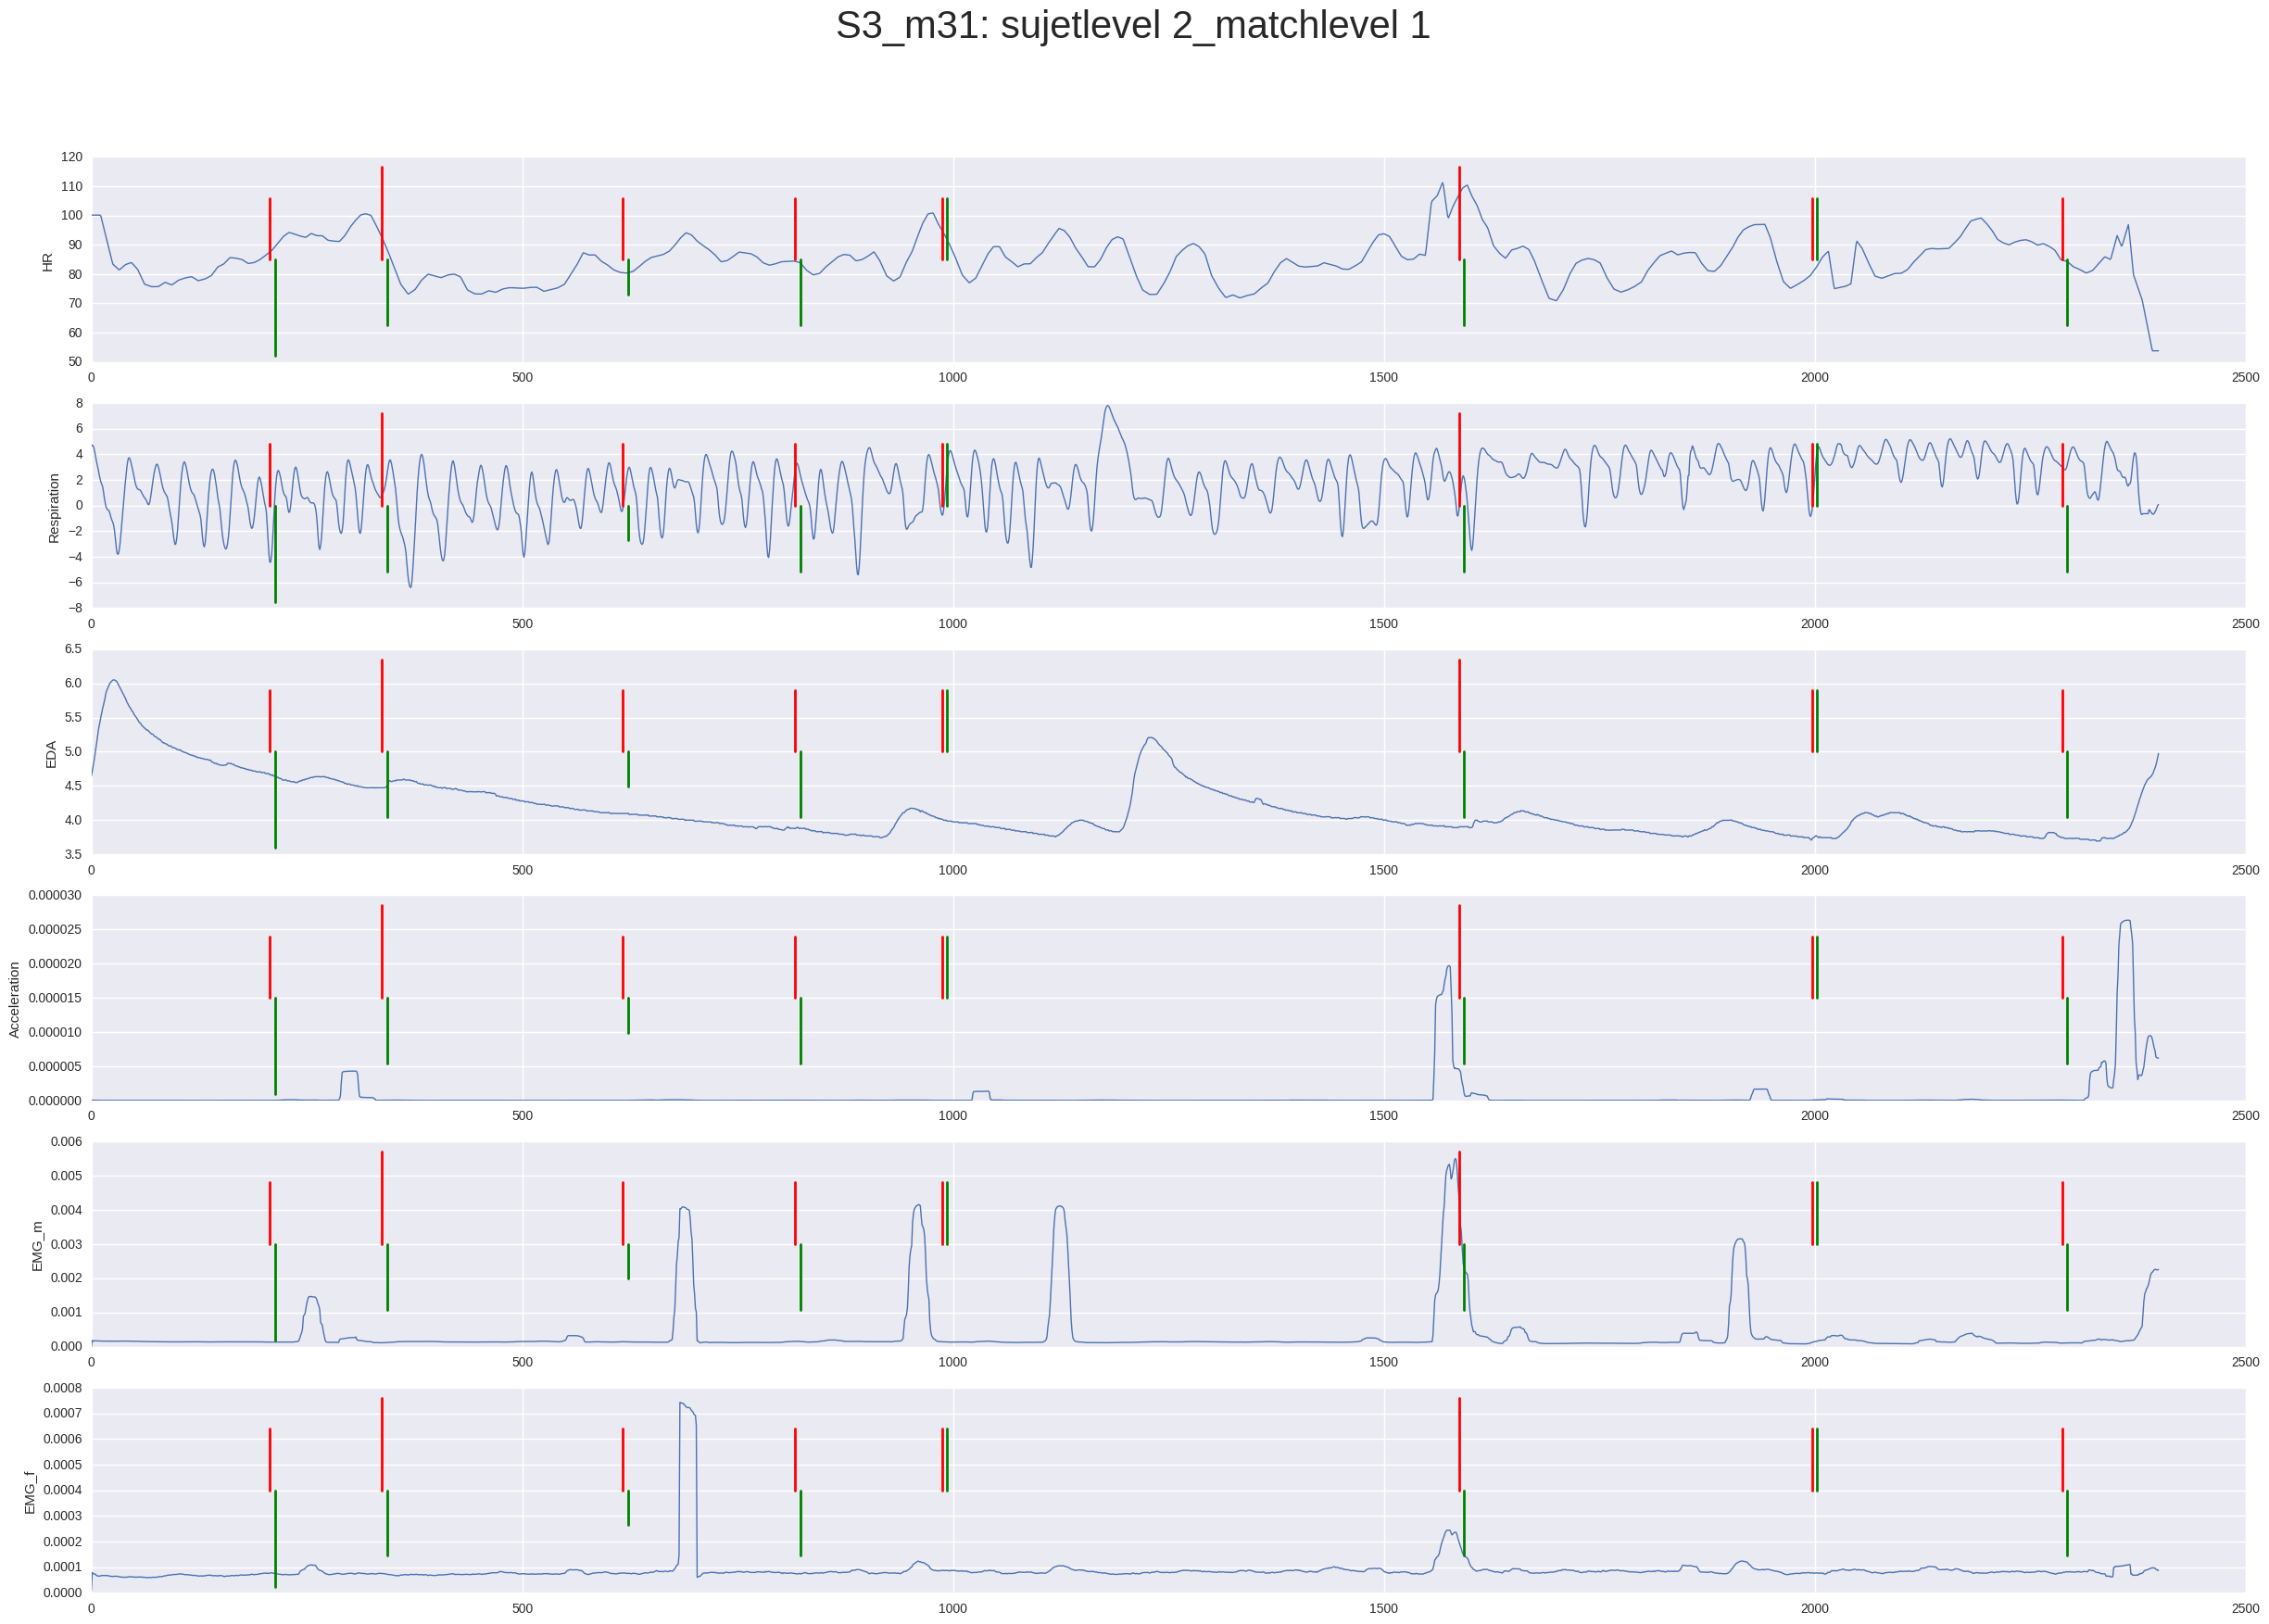

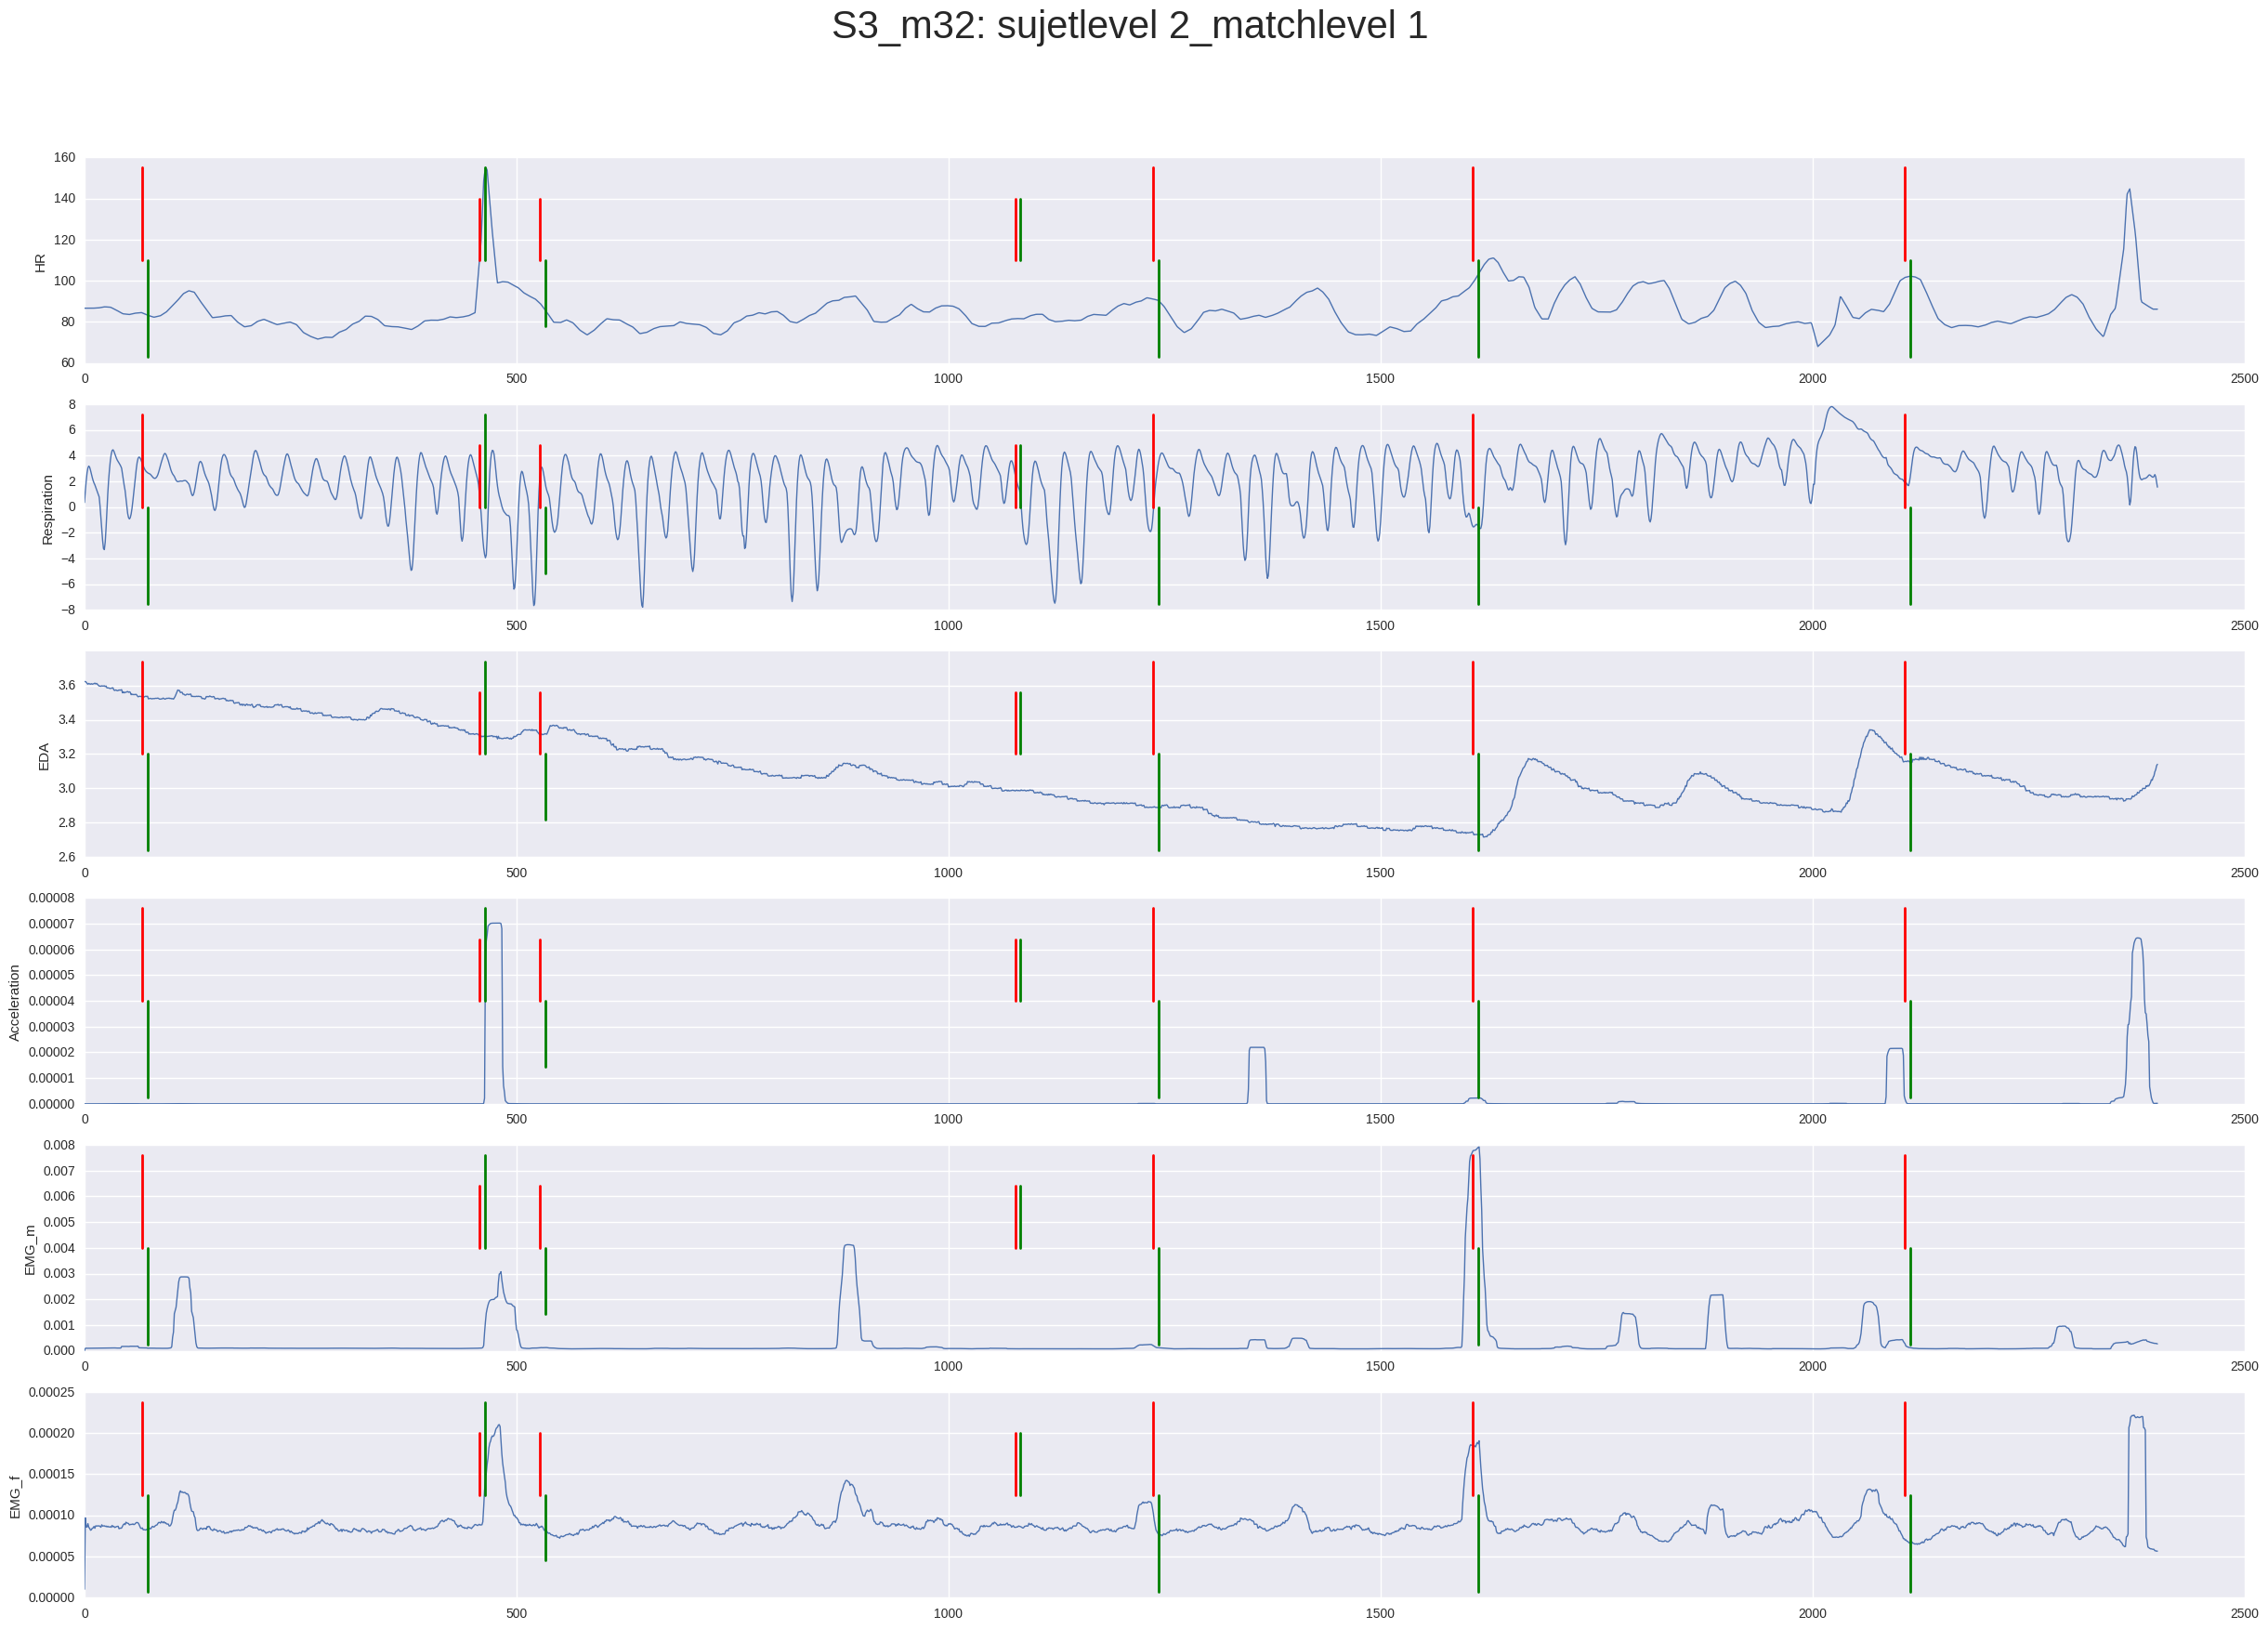

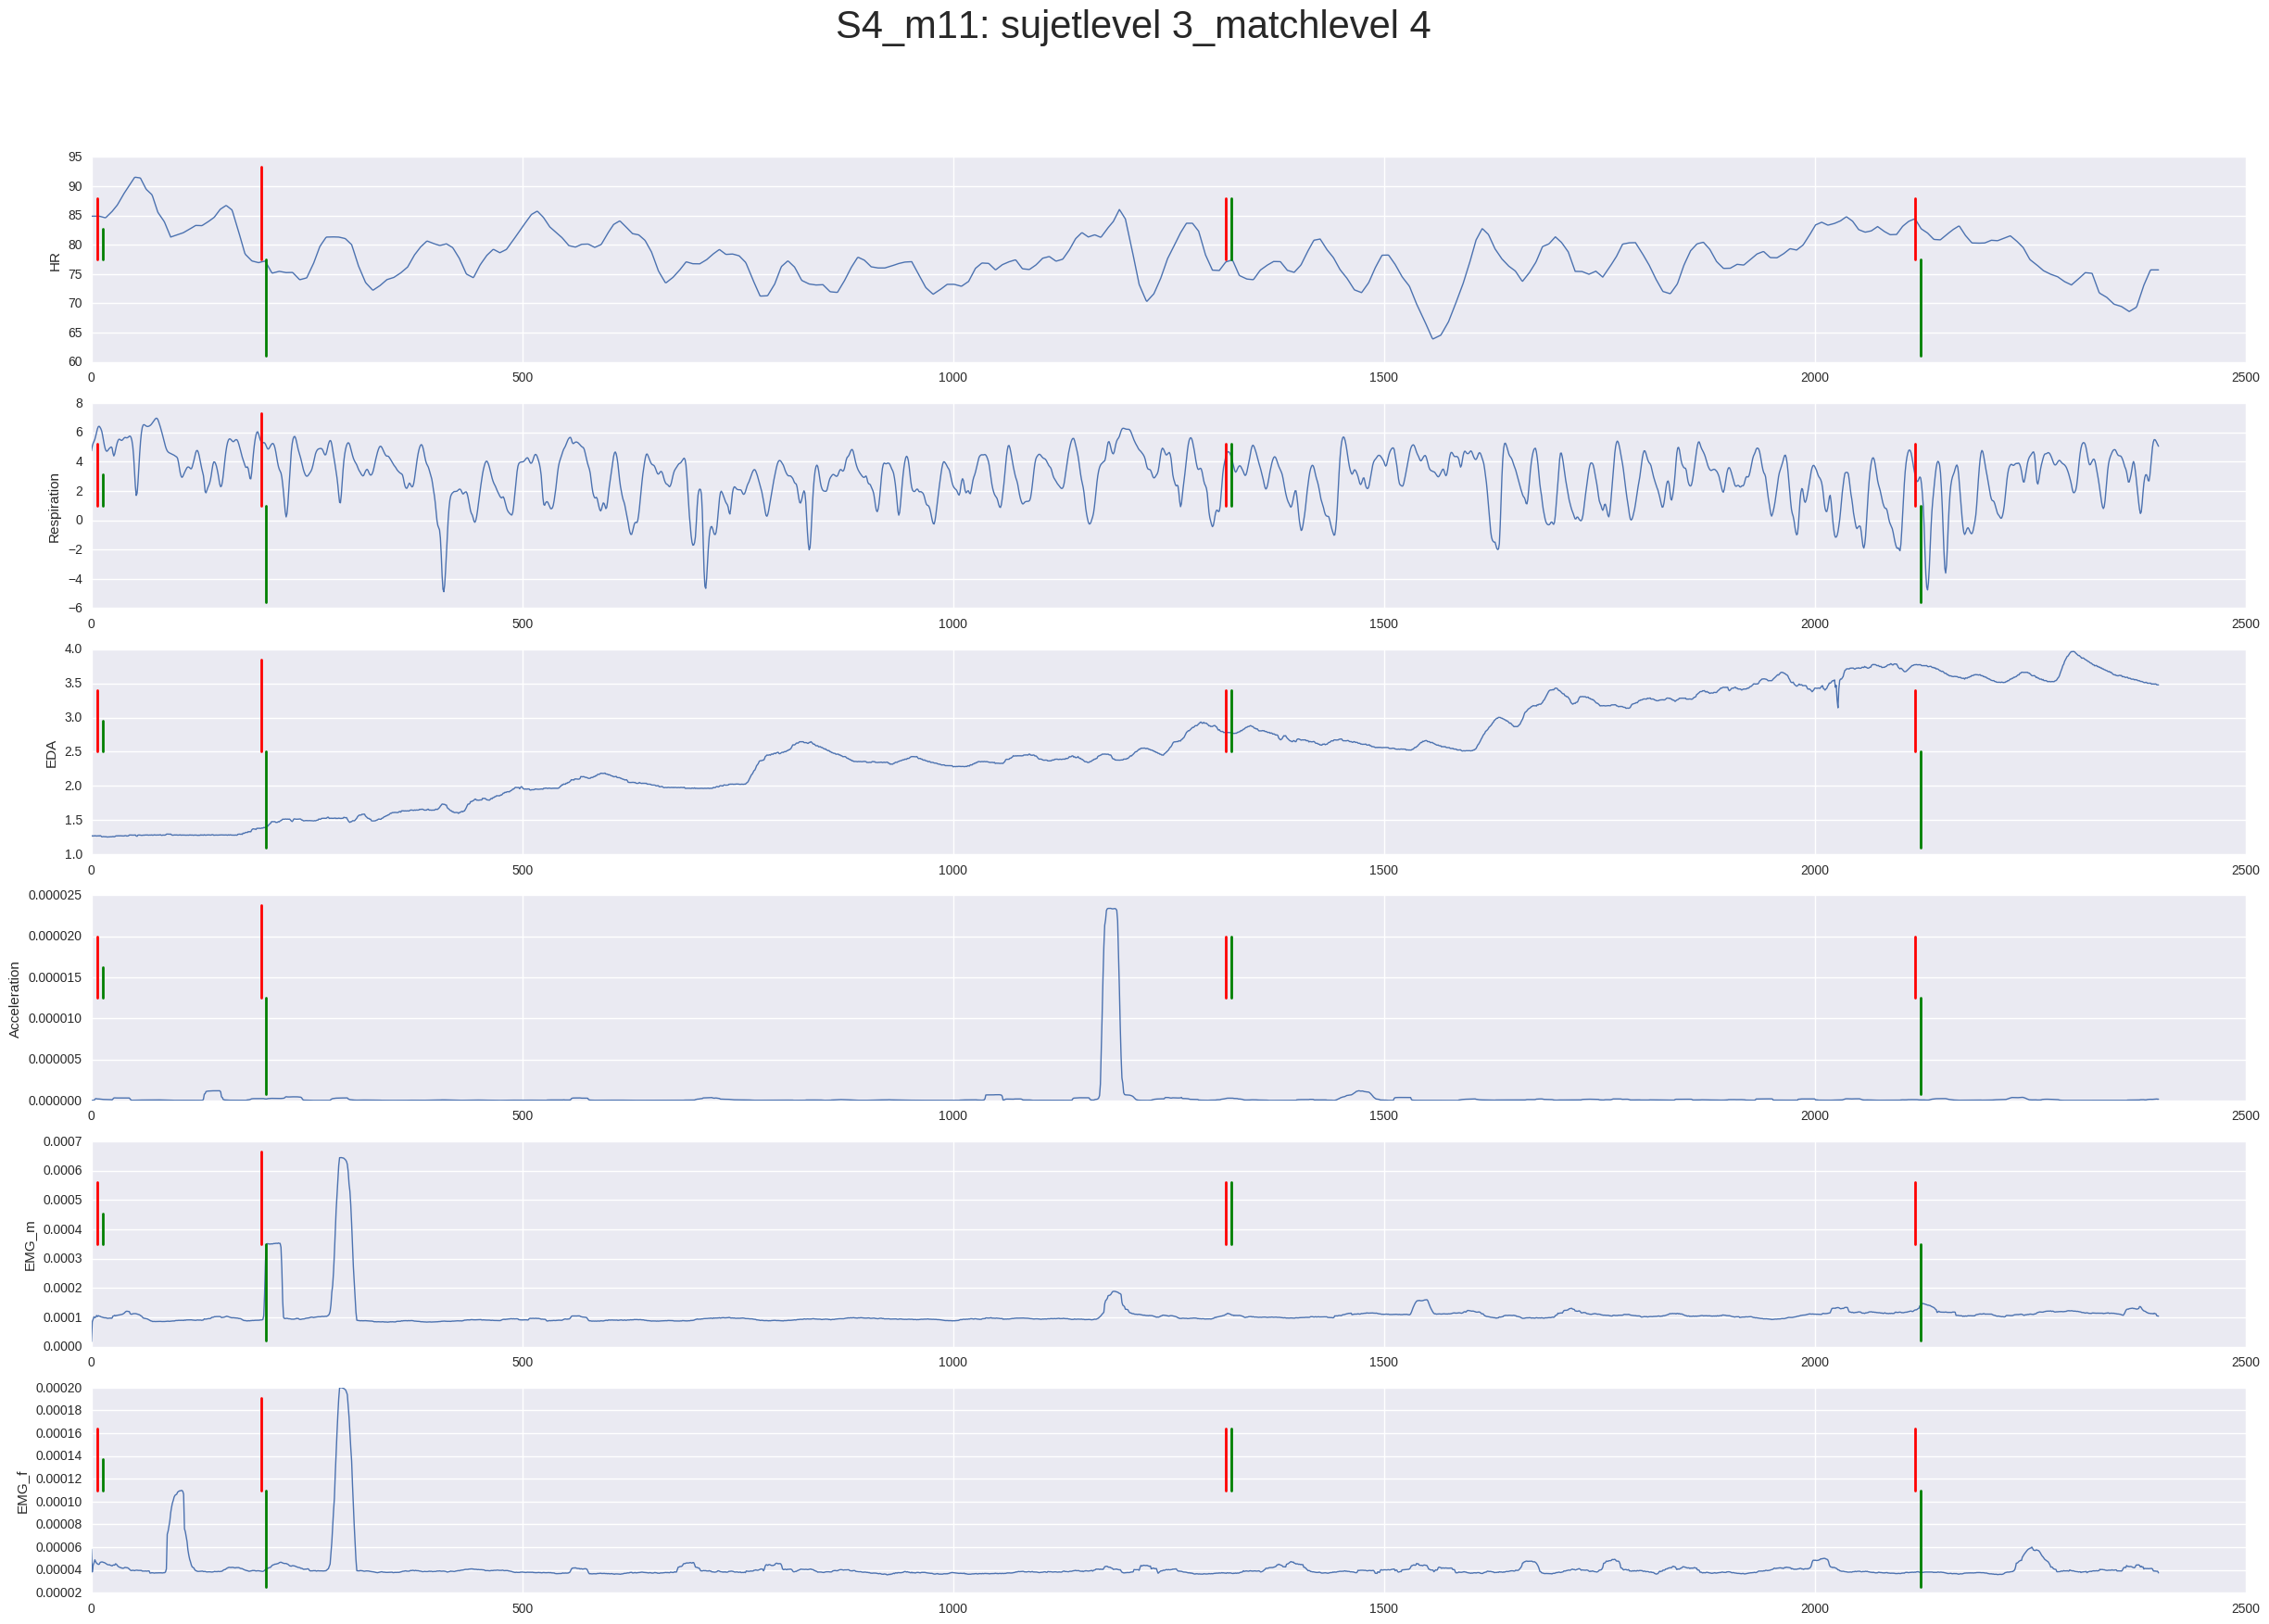

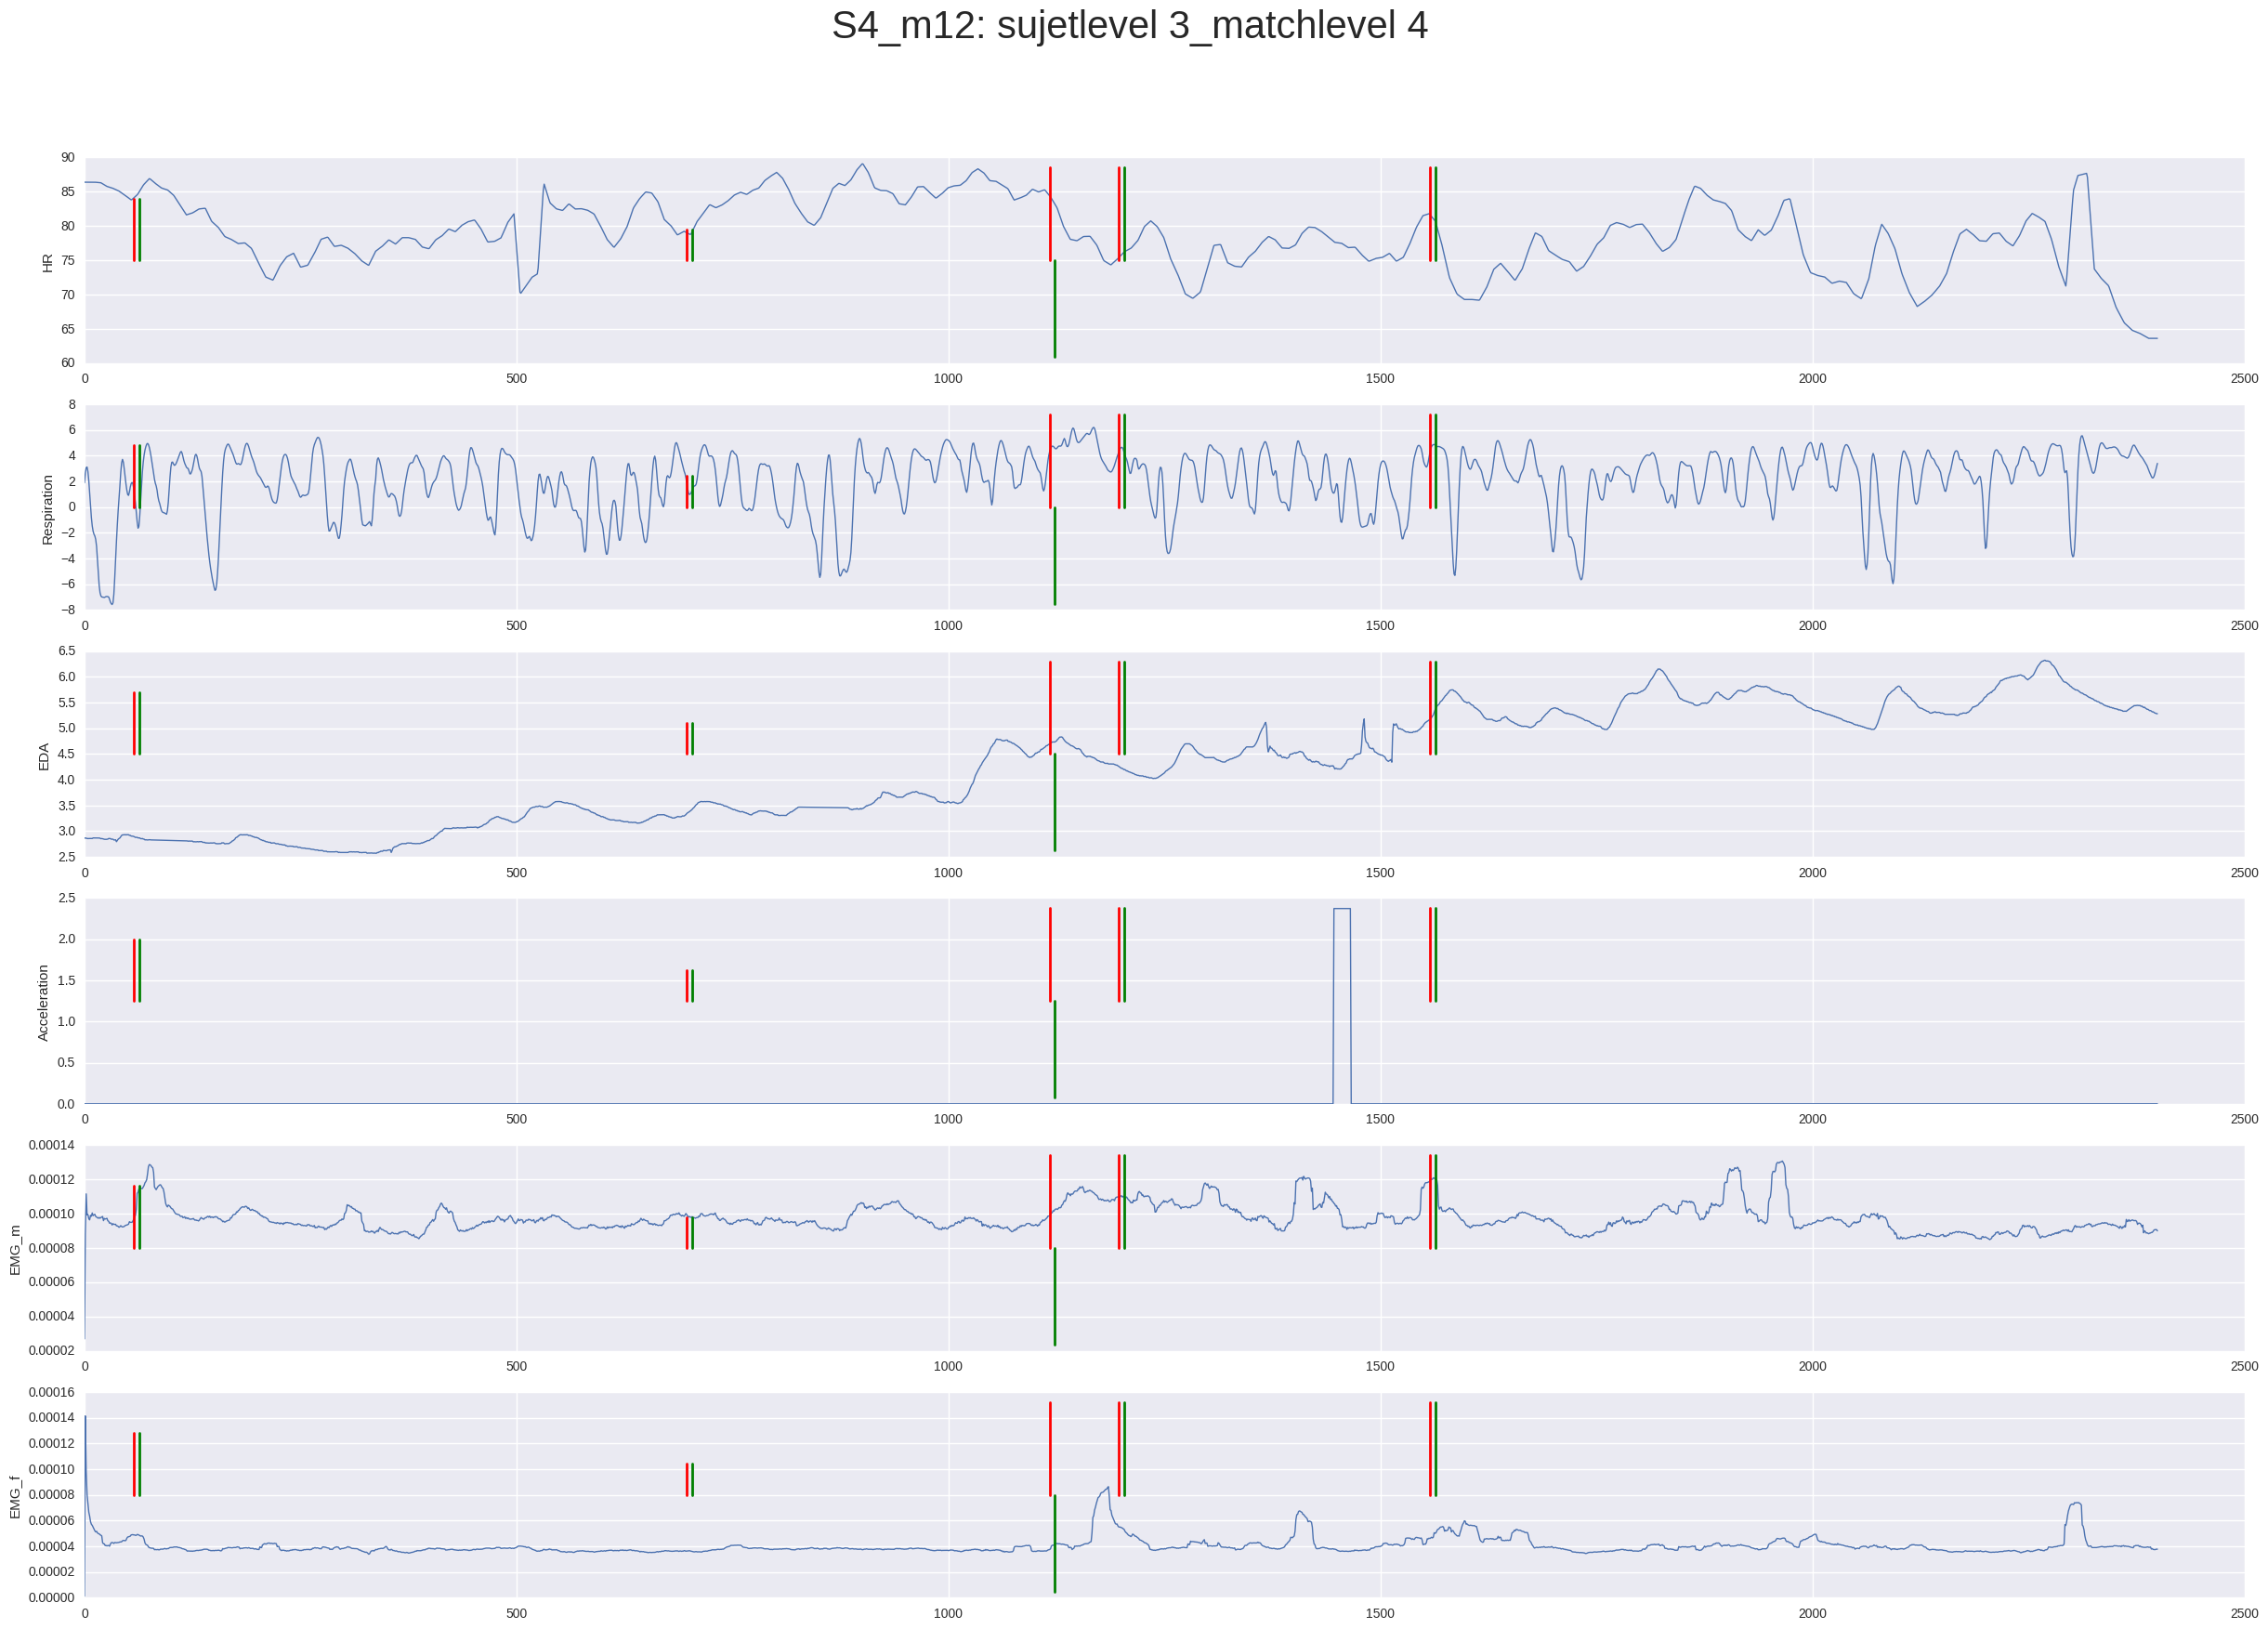

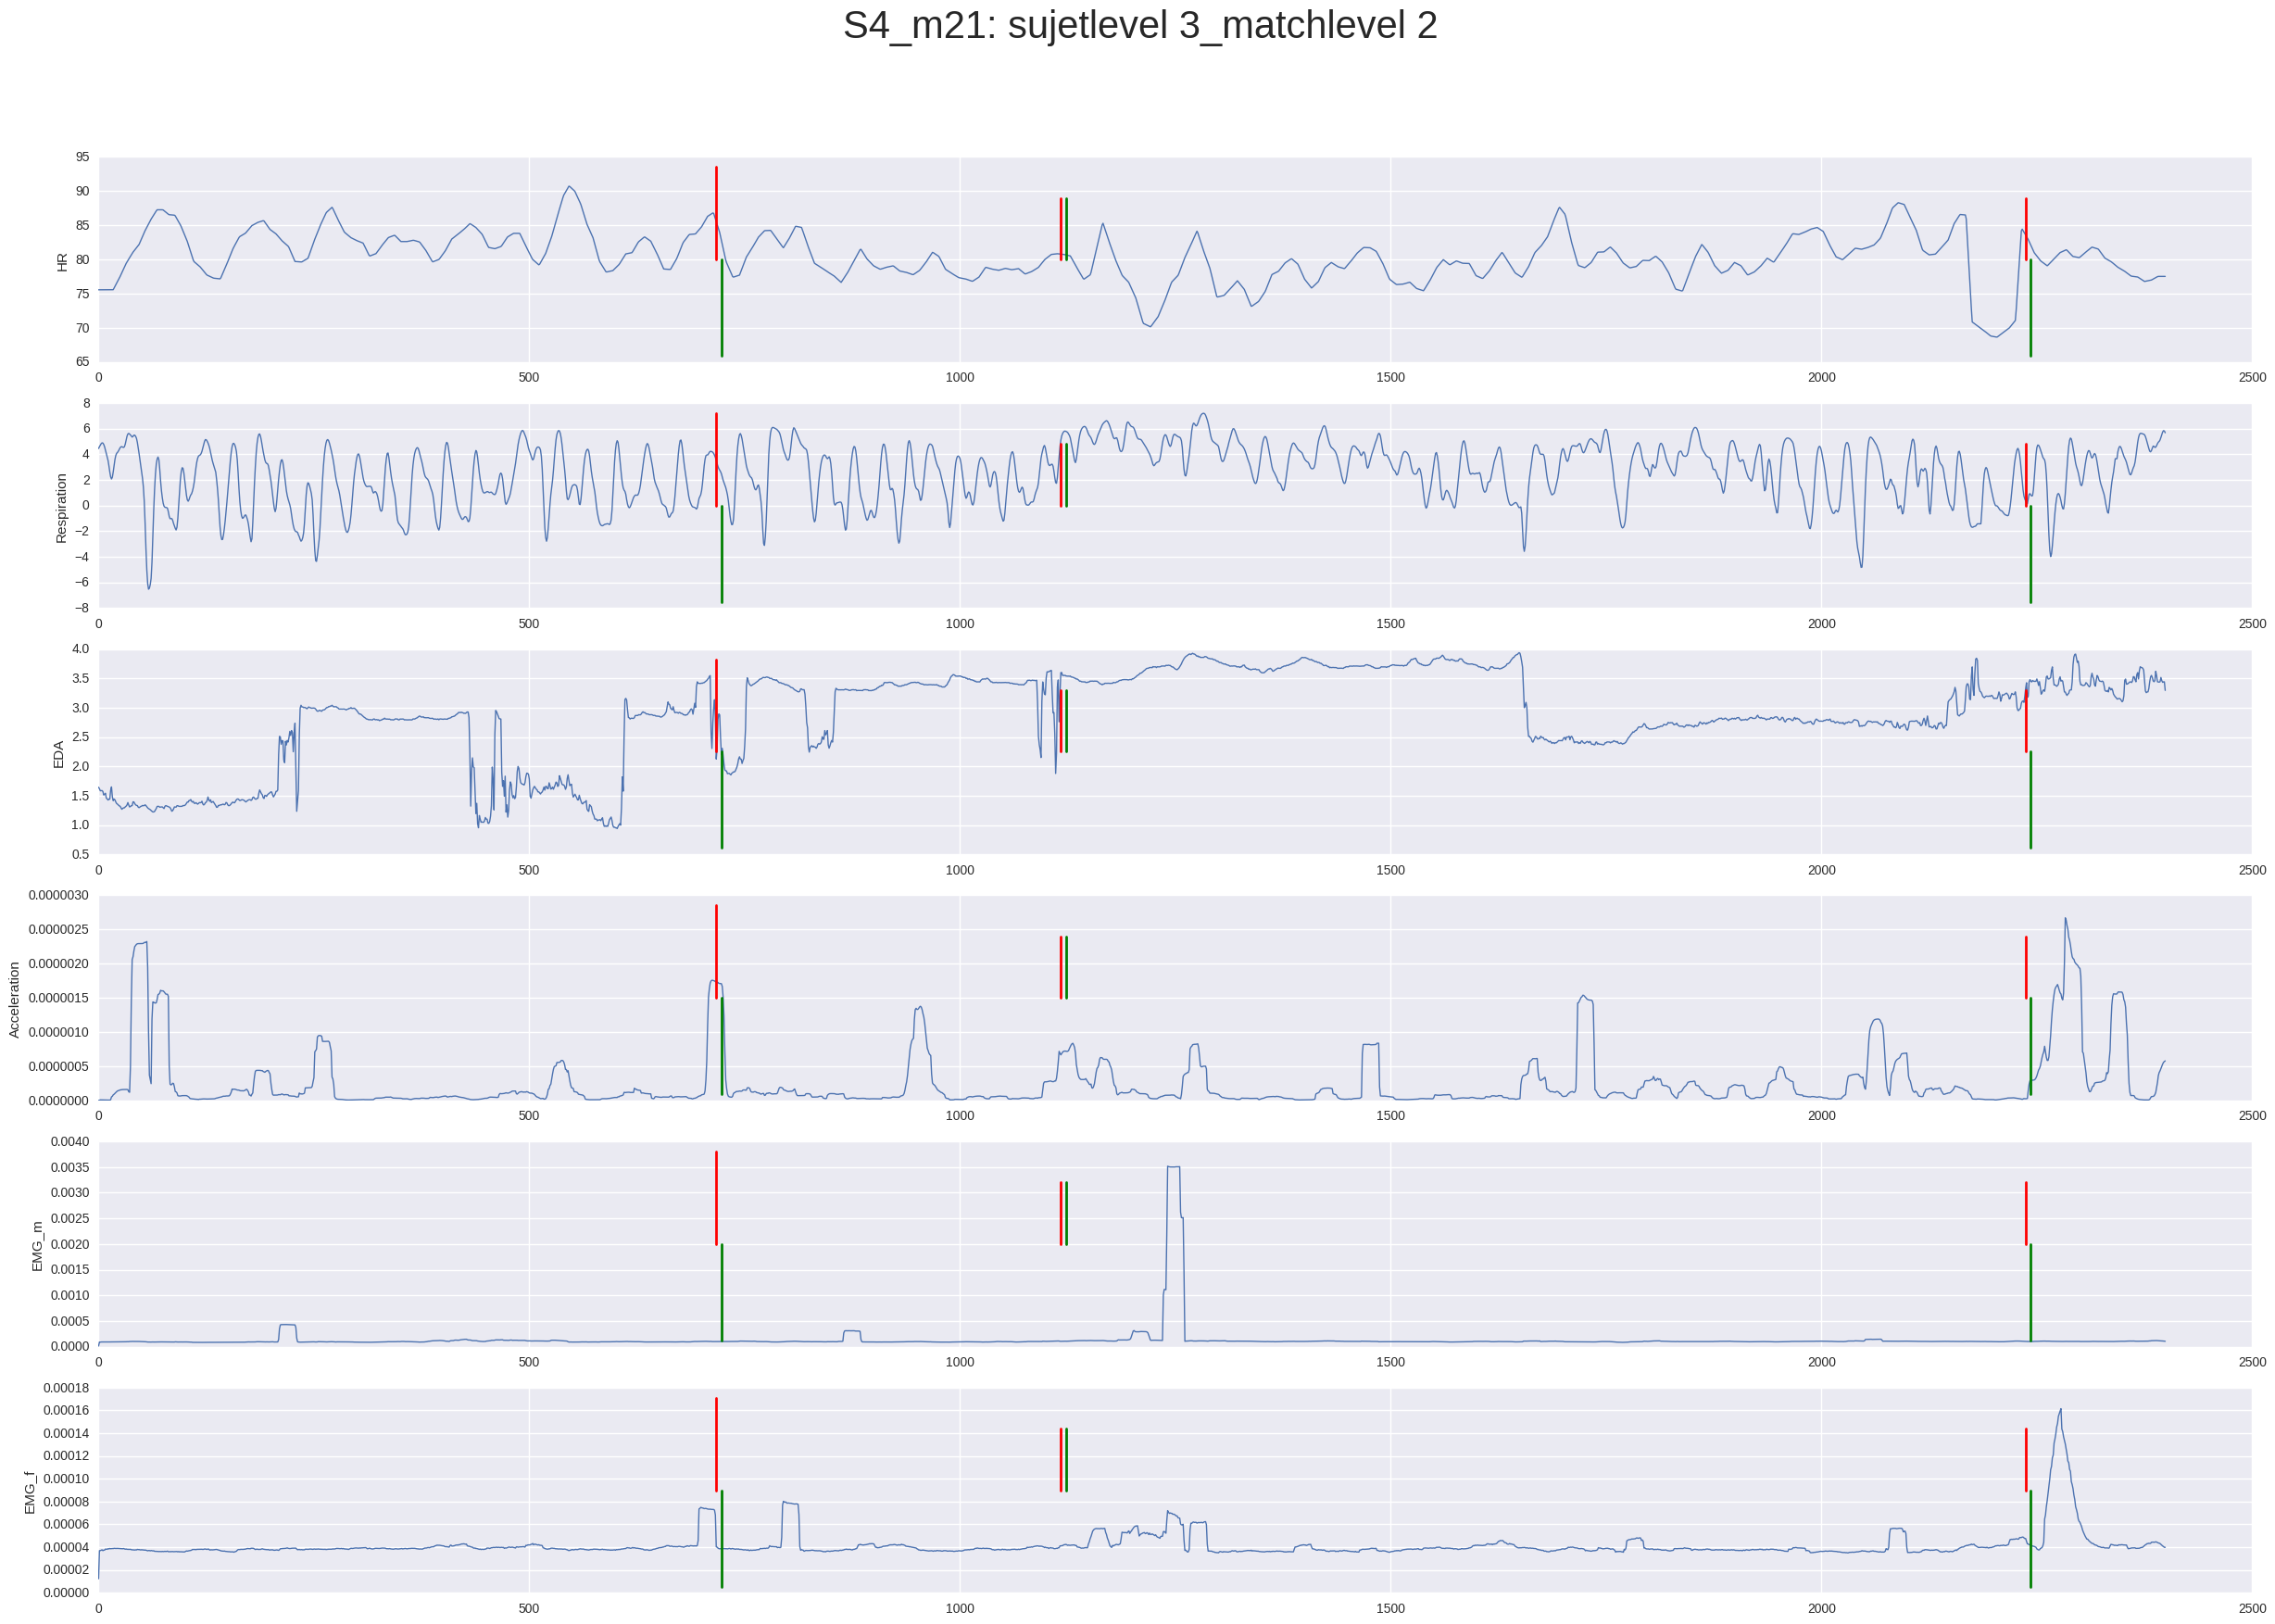

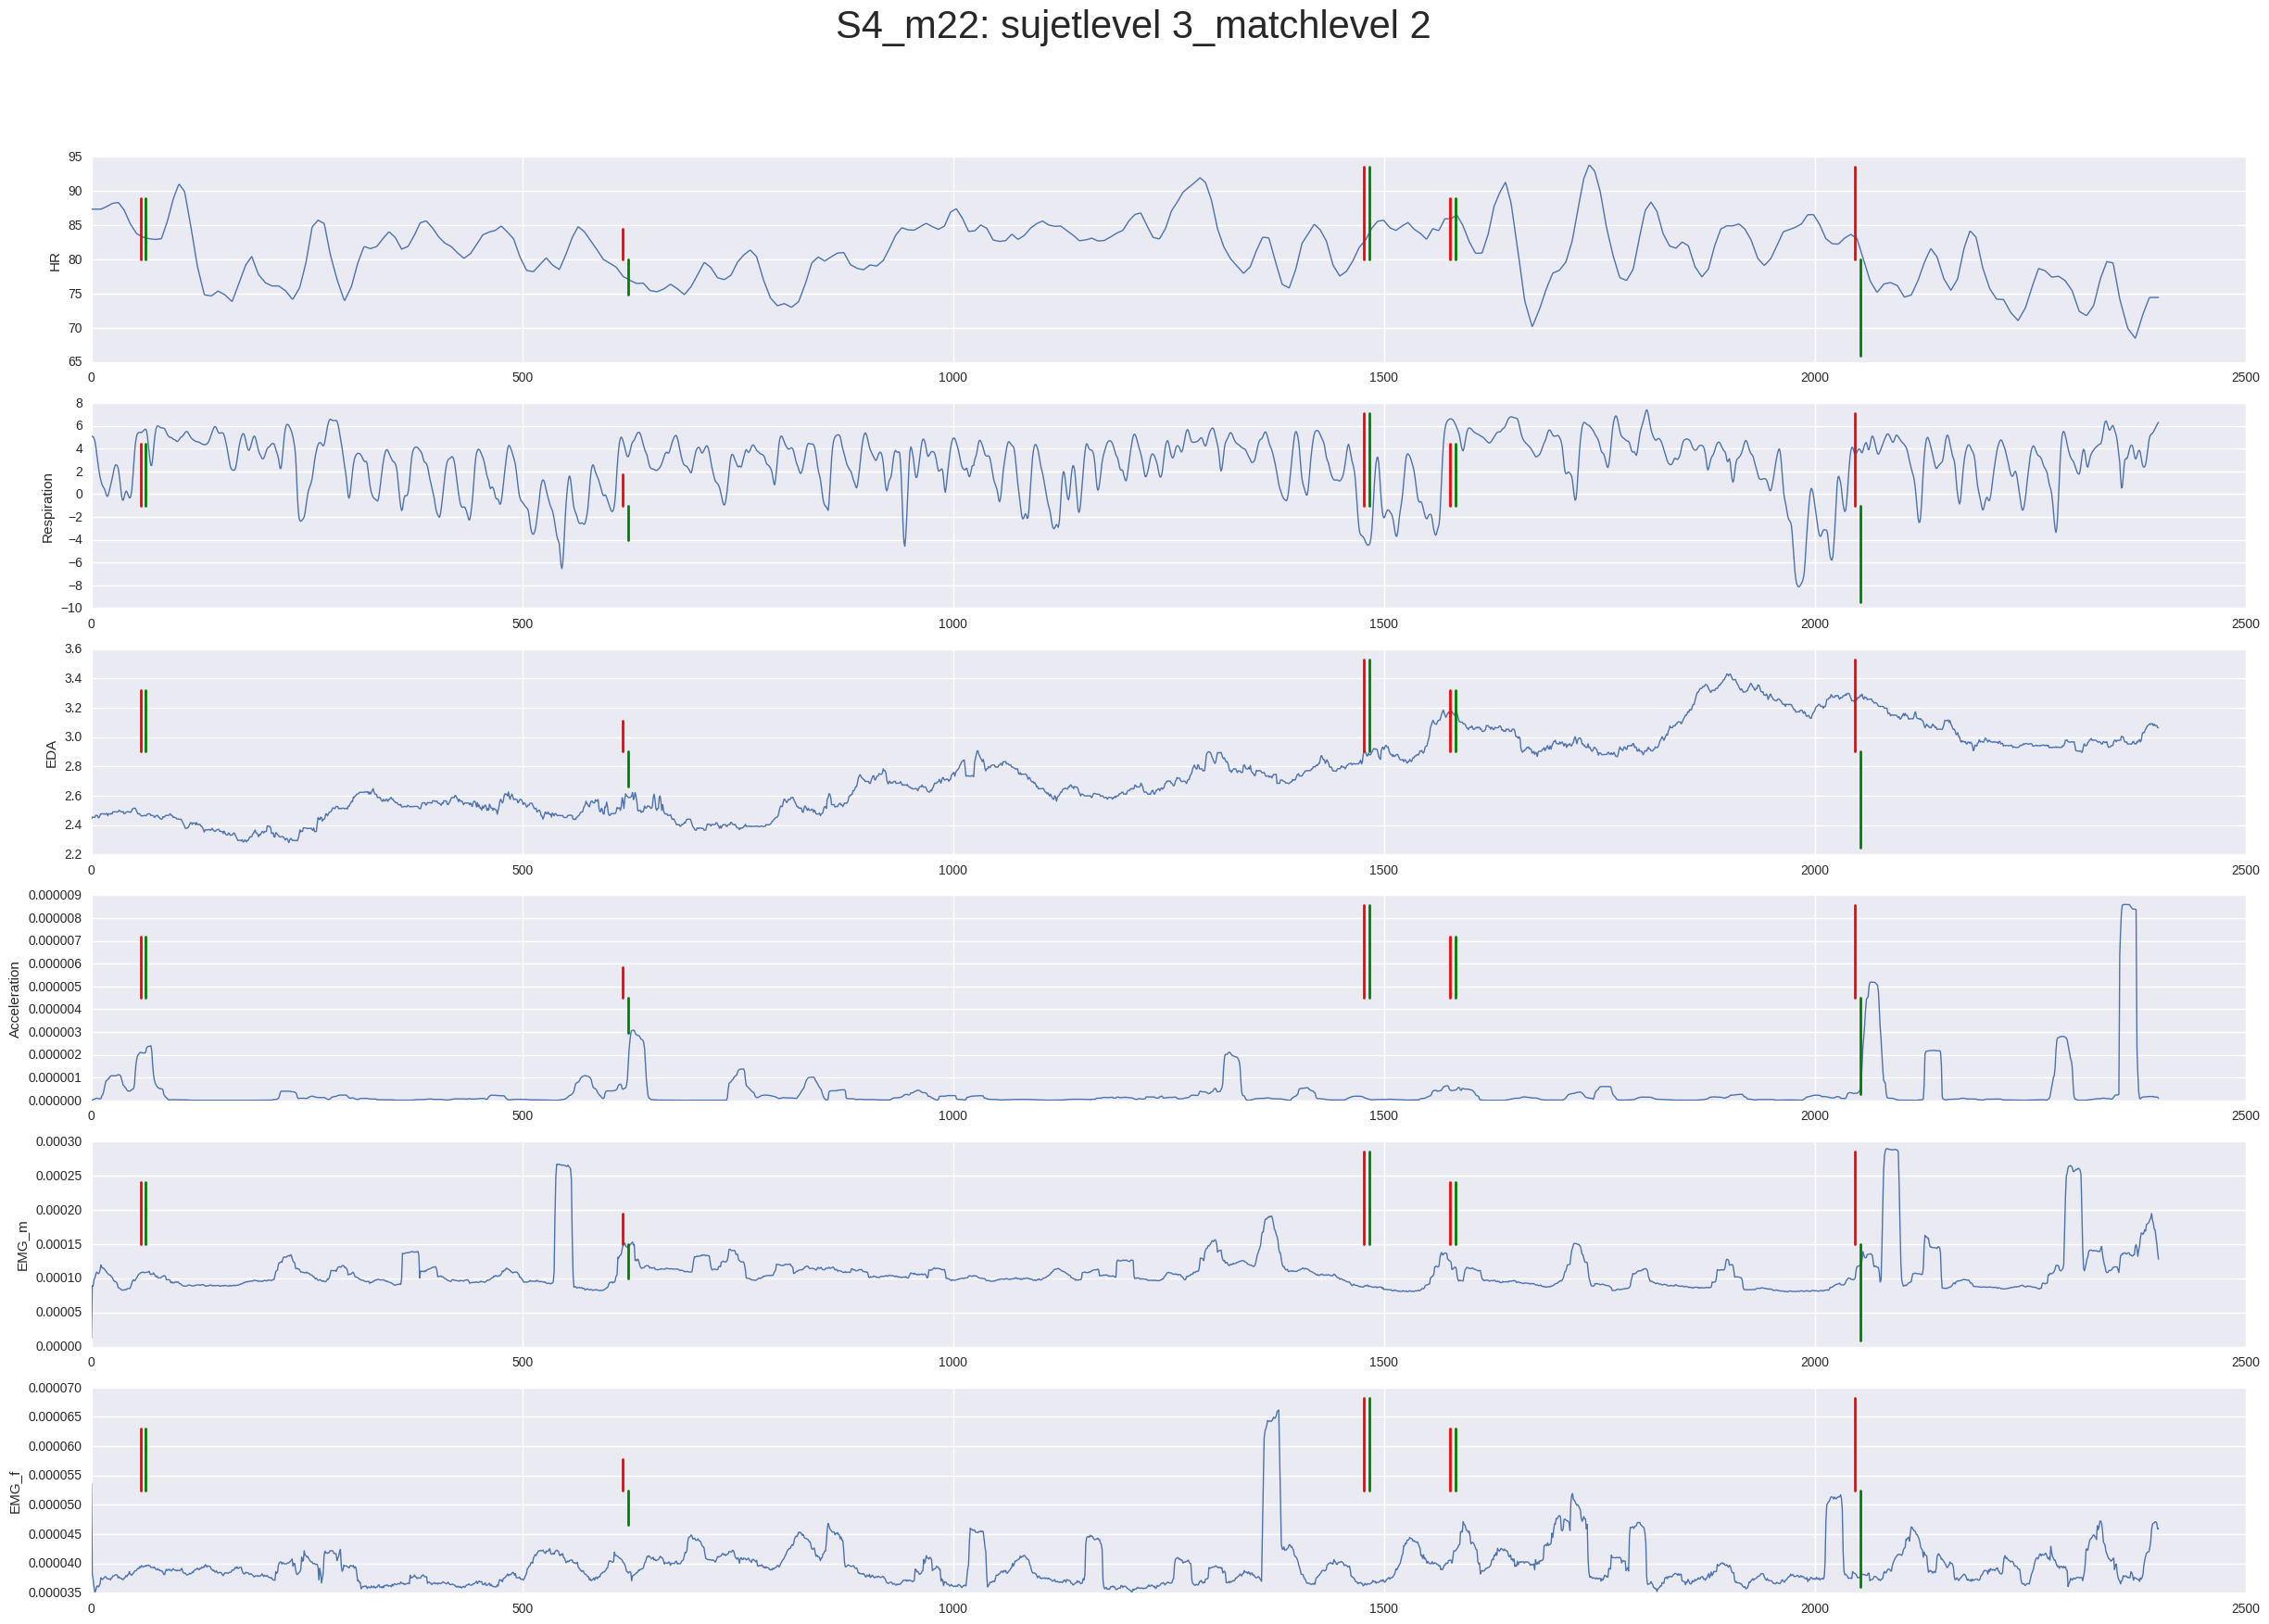

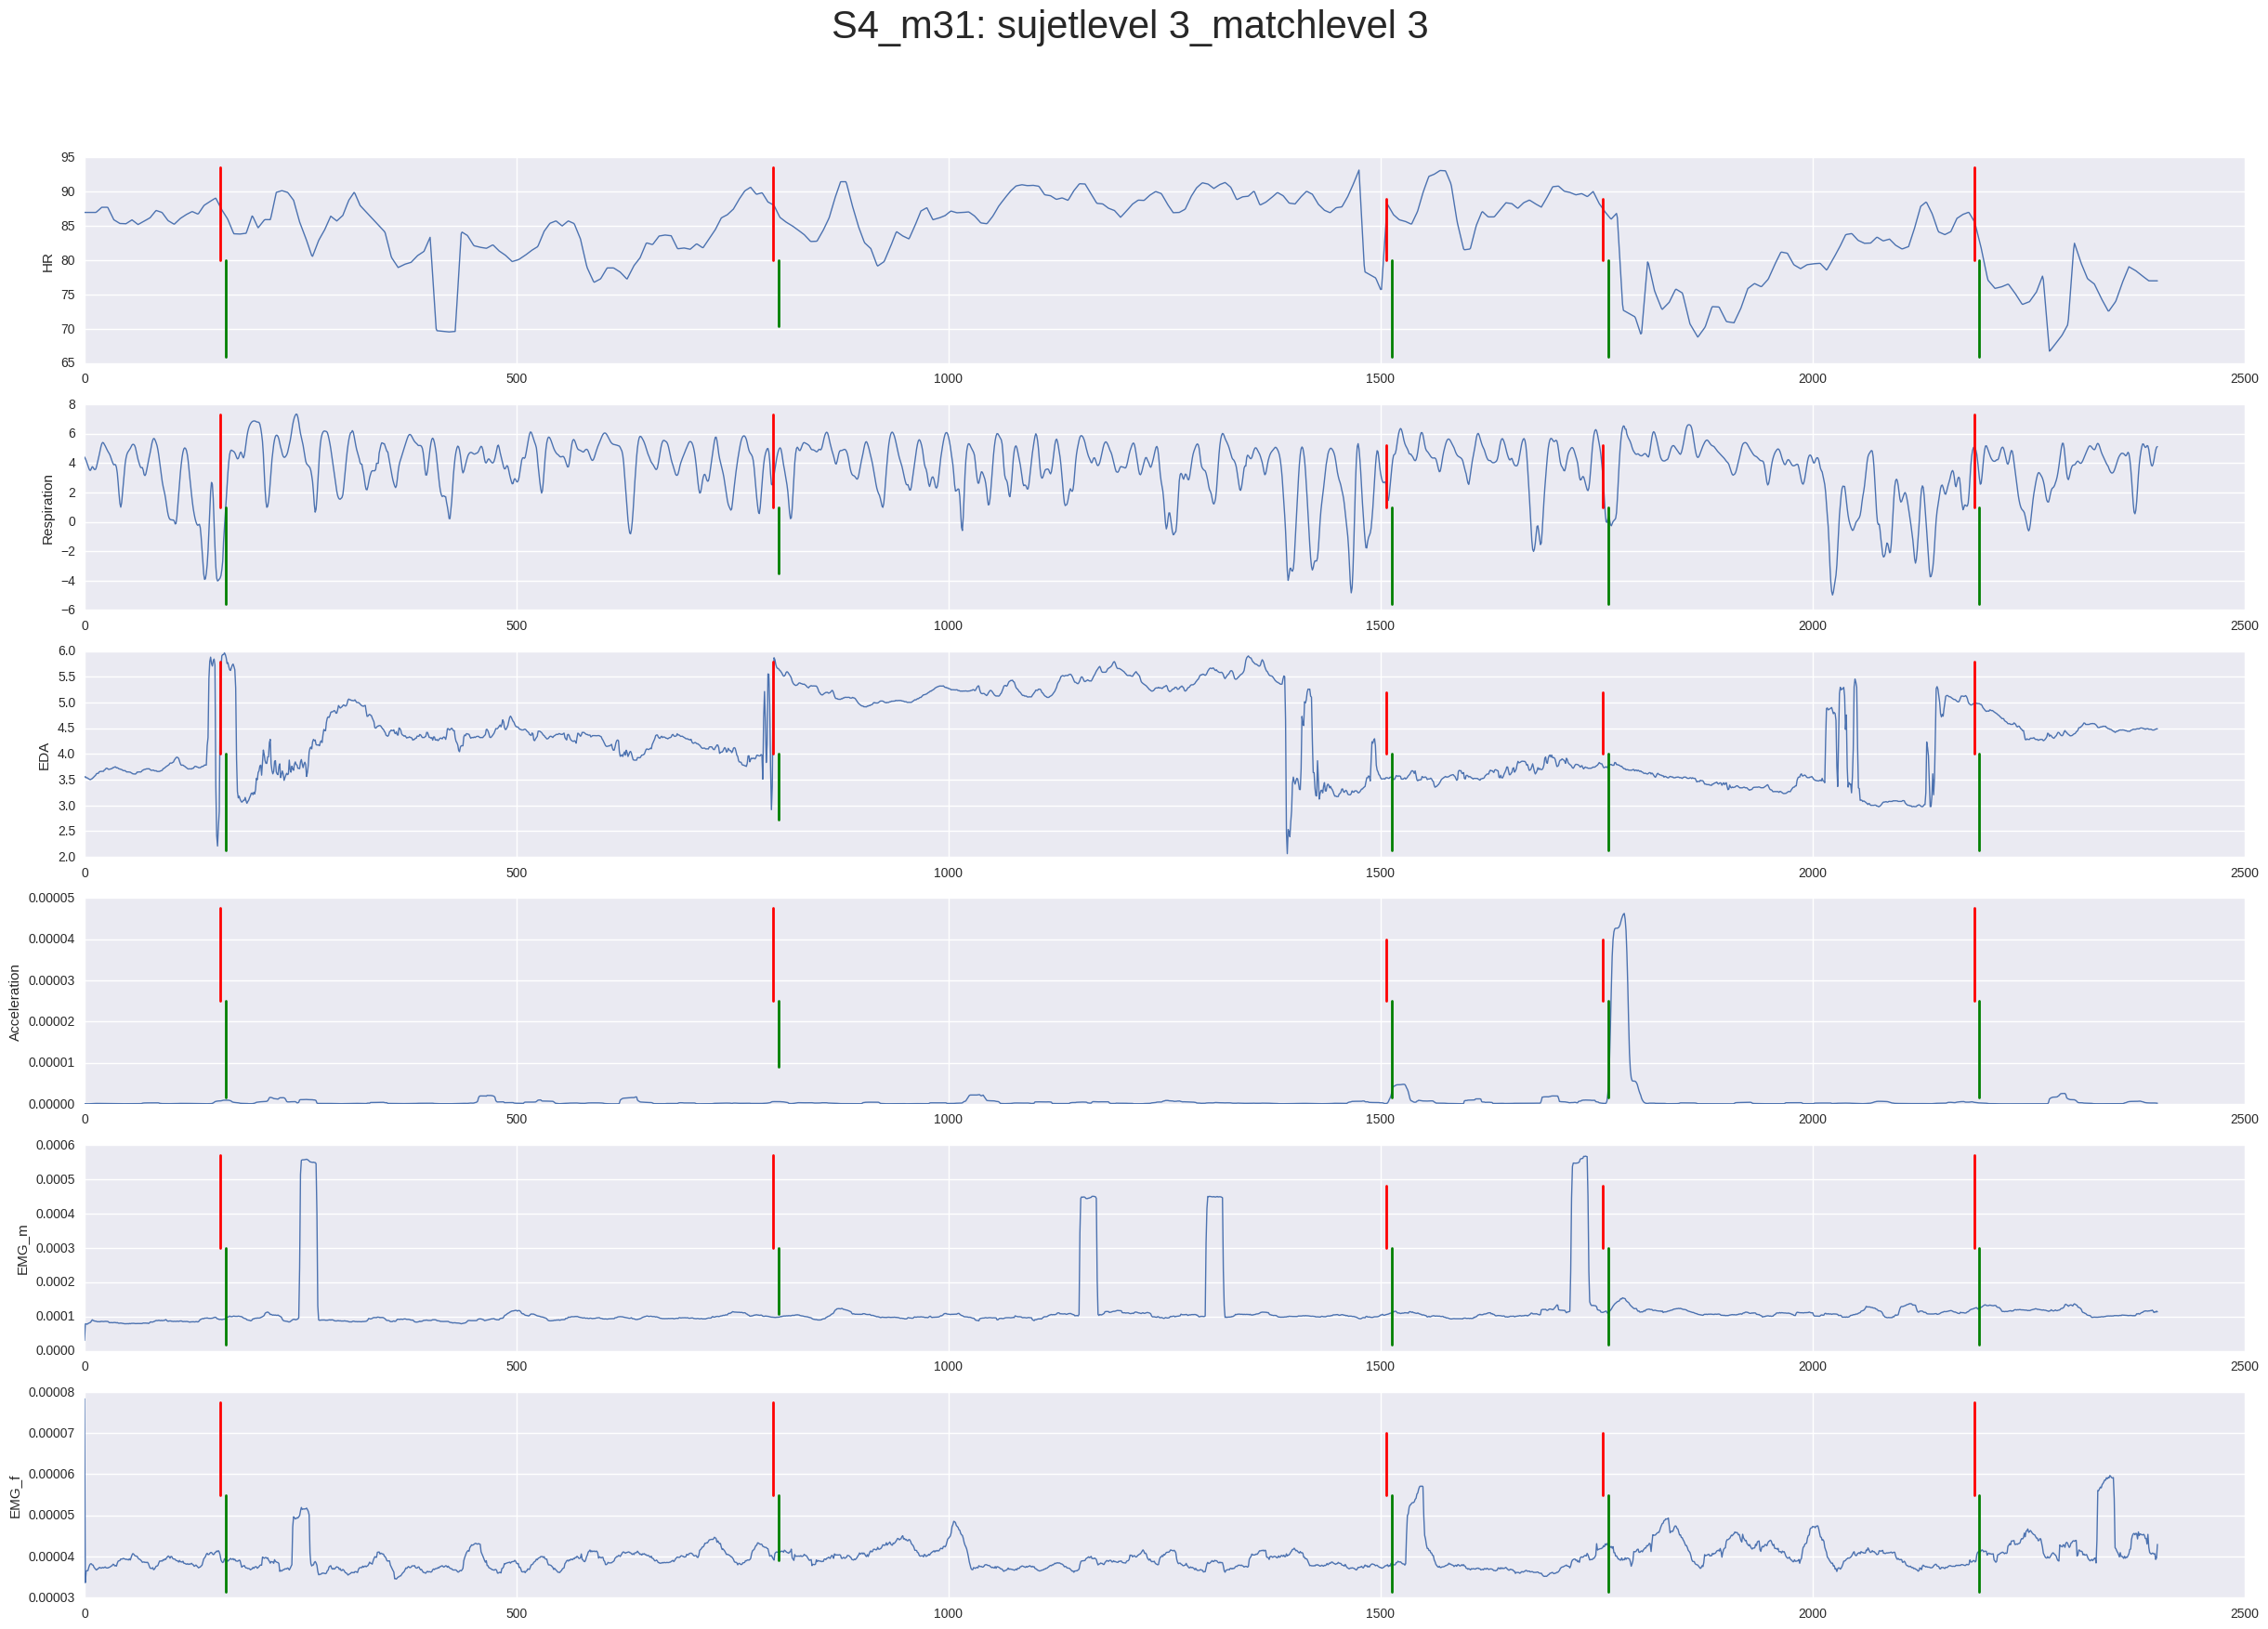

In [ ]:
# plot all 
dfAll = pd.read_csv('./../out/Allevent.txt',encoding='utf-16',index_col=0)
bioMatchPath="./../biopacMatchTrans/"
sample_freq=10
for sujet in range(2,59):
    for sequence in ['m11','m12','m21','m22','m31','m32']:
        fn='S'+str(sujet)+'_'+sequence+'.txt'
        matchFilename=bioMatchPath+fn
        #print fn
        try:
            chunkdf=pd.read_csv(matchFilename,sep=',',encoding="utf-16")
        except:
            print fn+' not found'
            continue
        #Get beginning timestamp (Absolute_sec) of selected sequence
        strsujet = 'S'+str(sujet)
        begin = Mdf[strsujet].ix[sequence,6]
        end = Mdf[strsujet].ix[sequence,4]

        #Get event list of selected sequence
        eventtmp=dfAll.ix[(dfAll['sujet']==int(sujet)) ,:]
        eventtmp=eventtmp[(eventtmp.Absolute_sec>begin)&(eventtmp.Absolute_sec<end)]
        eventtmp['rela_point']=pd.Series((eventtmp.Absolute_sec-begin)*sample_freq) #event point respect to the beginning timestamp
        #eventtmp
        #print matchFilename, len(eventtmp)
        plotseq(chunkdf,sujet,sequence,eventtmp)

./../biopacMatchTrans/S2_m11.txt


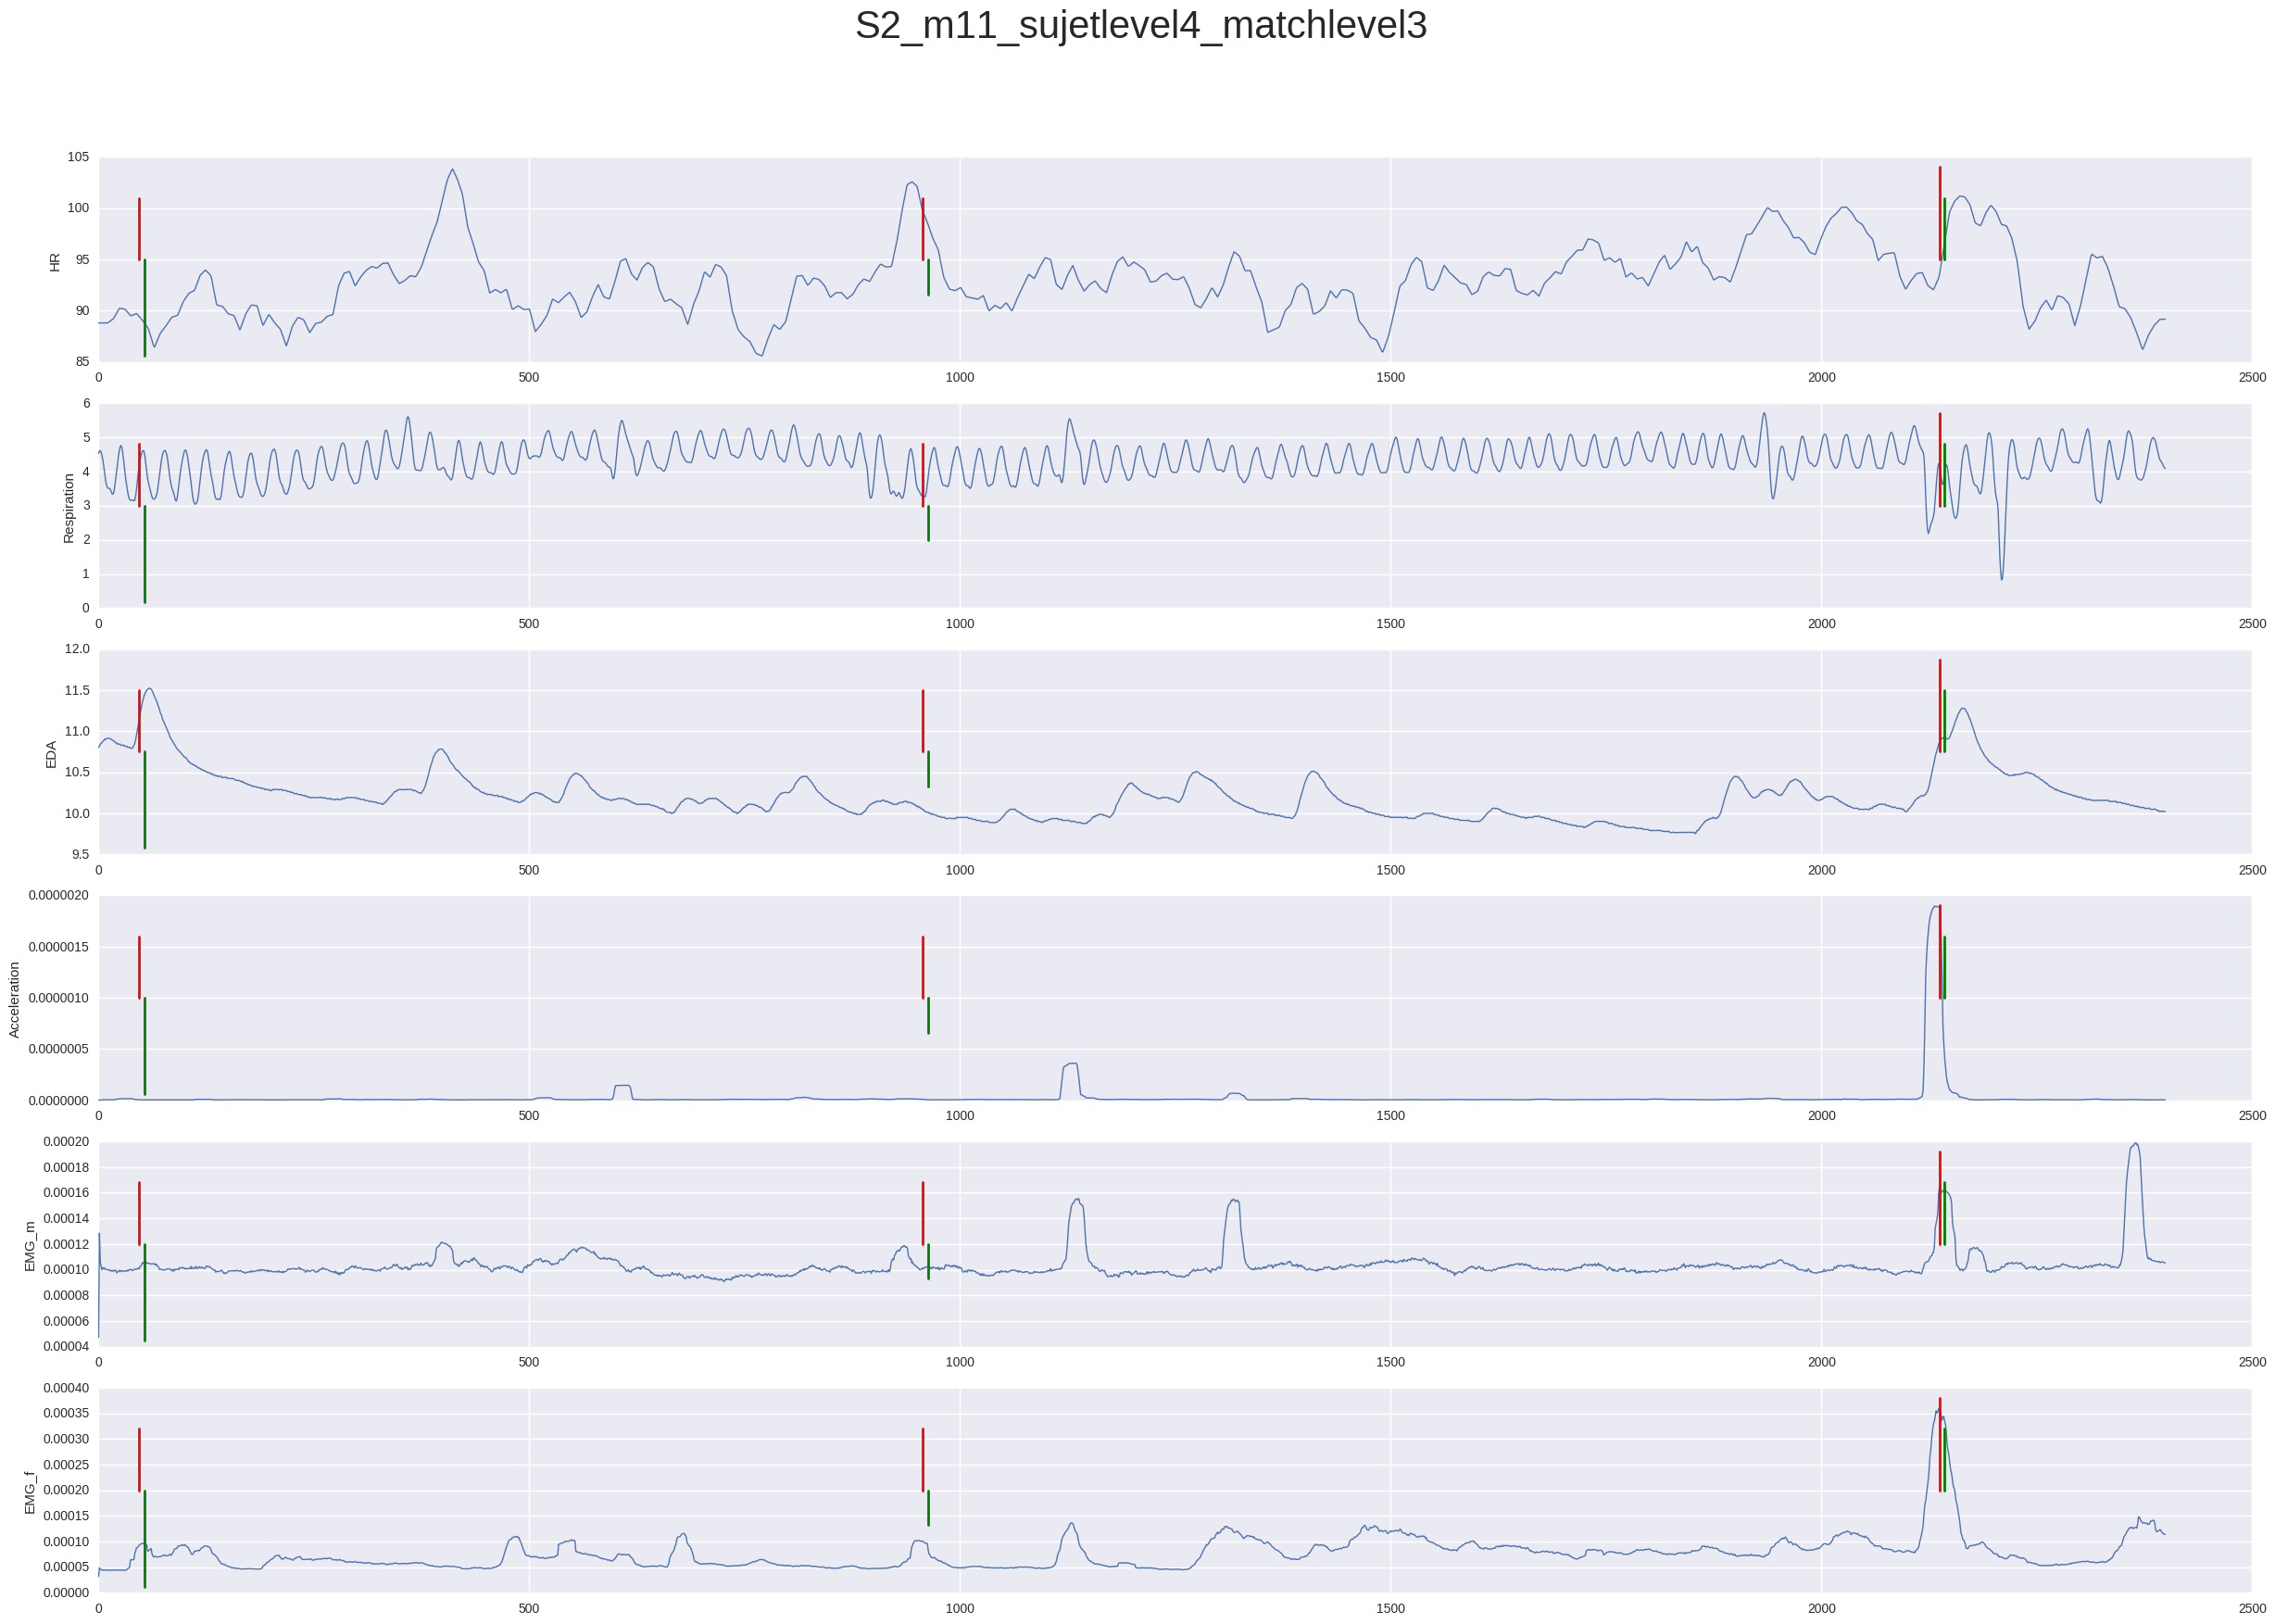

In [82]:
sample_freq=10
sujet = 2
sequence = 'm11'
bioMatchPath="./../biopacMatchTrans/"
#Read Biopac files of selected sequence : exp: ./../biopacMatch/S4_m12.txt
matchFilename=bioMatchPath+"S"+str(sujet)+"_"+sequence+".txt"
print matchFilename
chunkdf=pd.read_csv(matchFilename,sep=',',encoding="utf-16")
#Get beginning timestamp (Absolute_sec) of selected sequence
strsujet = 'S'+str(sujet)
begin = Mdf[strsujet].ix[sequence,6]
end = Mdf[strsujet].ix[sequence,4]

#Get event list of selected sequence
eventtmp=dfAll.ix[(dfAll['sujet']==sujet) ,:]
eventtmp=eventtmp[(eventtmp.Absolute_sec>begin)&(eventtmp.Absolute_sec<end)]
eventtmp['rela_point']=pd.Series((eventtmp.Absolute_sec-begin)*sample_freq) #event point respect to the beginning timestamp
#eventtmp
plotseq(chunkdf,sujet,sequence,eventtmp)